In [271]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import glob
import tqdm
import random
import pickle
from collections import defaultdict
import requests
import PIL


import sklearn
import sklearn.svm
import sklearn.model_selection
from sklearn.model_selection import train_test_split



print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline
%load_ext autoreload
%autoreload 2

PyTorch Version:  1.7.1+cpu
Torchvision Version:  0.8.2+cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Different Models and Layers

In [27]:
batch_size = 8
num_epochs = 5
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes=1000, feature_extract=True, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [210]:
model_ft, input_size = initialize_model("squeezenet")
model_ft.eval()

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [234]:
img = PIL.Image.open("C:\\Users\\islam\\downloads\\apple3.jpg").convert("RGB")
tensor = data_transforms["val"](img).unsqueeze(0)

In [233]:
# model_ft

In [251]:
list(list(model_ft.children())[0].children())[15:]

SyntaxError: can't use starred expression here (<ipython-input-251-9fdc94ca21cb>, line 1)

In [263]:
class SqueezenetBottom(nn.Module):
    def __init__(self, original_model, flatten, layer_idx):
        super(SqueezenetBottom, self).__init__()
        if flatten:
            self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:layer_idx], nn.Flatten())
        else:
            self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:layer_idx])

    def forward(self, x):
        x = self.features(x)
        return x

class SqueezenetTop(nn.Module):
    def __init__(self, original_model, shape, layer_idx):
        super(SqueezenetTop, self).__init__()
        self.features = nn.Sequential(*list(list(original_model.children())[0].children())[layer_idx:], *list(original_model.children())[1])
        self.shape = shape

    def forward(self, x):
        shape = self.shape
        x = x.view((-1, shape[1], shape[2], shape[3]))
        x = self.features(x)
        x = x.view((-1, 1000))
        x = nn.Softmax(dim=-1)(x)
        return x

def get_model_parts(model, layer_idx):    
    model_bottom = SqueezenetBottom(model, flatten=False, layer_idx=layer_idx)
    shape = model_bottom(tensor).shape
    model_bottom = SqueezenetBottom(model, flatten=True, layer_idx=layer_idx)
    model_top = SqueezenetTop(model, shape, layer_idx)
    return model_bottom, model_top



In [269]:
for layer_idx in range(13):
    model_bottom, model_top = get_model_parts(model_ft, layer_idx=layer_idx)
    model_bottom.eval()
    model_top.eval();

    embedding = model_bottom(tensor)
    print(layer_idx, embedding.shape)
    output = model_top(embedding)
    print(output.shape)    

0 torch.Size([1, 150528])
torch.Size([1, 1000])
1 torch.Size([1, 1140576])
torch.Size([1, 1000])
2 torch.Size([1, 1140576])
torch.Size([1, 1000])
3 torch.Size([1, 279936])
torch.Size([1, 1000])
4 torch.Size([1, 373248])
torch.Size([1, 1000])
5 torch.Size([1, 373248])
torch.Size([1, 1000])
6 torch.Size([1, 746496])
torch.Size([1, 1000])
7 torch.Size([1, 186624])
torch.Size([1, 1000])
8 torch.Size([1, 186624])
torch.Size([1, 1000])
9 torch.Size([1, 279936])
torch.Size([1, 1000])
10 torch.Size([1, 279936])
torch.Size([1, 1000])
11 torch.Size([1, 373248])
torch.Size([1, 1000])
12 torch.Size([1, 86528])
torch.Size([1, 1000])


In [272]:
for layer_idx in [0, 3, 7, 9, 10]:
    concept_dict = {}
    concept_dir = "concept_data/"
    transform = data_transforms['val']

    # iterate through each folder
    for concept in tqdm.tqdm(os.listdir(concept_dir)):
        if concept in concept_dict:
            continue

        all_embeddings = []
        all_labels = []

        image_dataset = datasets.ImageFolder(os.path.join(concept_dir,concept), transform)
        dataloaders = torch.utils.data.DataLoader(image_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

        # load all of the images, get the embeddings
        for inputs, labels in dataloaders:
            embeddings = model_bottom(inputs)
            all_embeddings.extend(embeddings.detach().numpy())
            all_labels.extend(labels.detach().numpy())

        # train an svm on the pos, neg
        X_train, X_test, y_train, y_test = train_test_split(all_embeddings, all_labels)
        svm = sklearn.svm.SVC(kernel="linear", C=0.0001, probability=True)
        svm.fit(X_train, y_train)
        train_acc = svm.score(X_train, y_train)
        test_acc = svm.score(X_test, y_test)

        # print test accuaracy
        print(train_acc, test_acc)
        # store svm coefs in dictionary
        concept_dict[concept] = (svm.coef_, train_acc, test_acc)      
    
    pickle.dump(concept_dict, open('sq_layer_{}_concepts_170.pkl'.format(layer_idx), 'wb'))    

  1%|▍                                                                               | 1/170 [00:48<2:17:57, 48.98s/it]

1.0 0.94


  1%|▉                                                                               | 2/170 [01:19<2:01:18, 43.33s/it]

1.0 0.9705882352941176


  2%|█▍                                                                              | 3/170 [01:45<1:46:42, 38.34s/it]

1.0 0.875


  2%|█▉                                                                              | 4/170 [02:40<1:59:55, 43.35s/it]

1.0 0.9


  3%|██▎                                                                             | 5/170 [03:34<2:07:41, 46.44s/it]

1.0 0.76


  4%|██▊                                                                             | 6/170 [04:31<2:15:30, 49.57s/it]

1.0 0.68


  4%|███▎                                                                            | 7/170 [05:23<2:17:06, 50.47s/it]

1.0 0.6


  5%|███▊                                                                            | 8/170 [06:17<2:19:06, 51.52s/it]

1.0 0.66


  5%|████▏                                                                           | 9/170 [07:02<2:12:20, 49.32s/it]

1.0 0.6590909090909091


  6%|████▋                                                                          | 10/170 [07:56<2:15:39, 50.87s/it]

1.0 0.72


  6%|█████                                                                          | 11/170 [08:48<2:15:25, 51.11s/it]

1.0 0.8


  7%|█████▍                                                                       | 12/170 [20:25<10:45:00, 244.94s/it]

1.0 0.76


  8%|█████▉                                                                        | 13/170 [21:08<8:02:28, 184.38s/it]

1.0 0.8333333333333334


  8%|██████▍                                                                       | 14/170 [22:01<6:16:59, 145.00s/it]

1.0 0.78


  9%|██████▉                                                                       | 15/170 [22:36<4:49:21, 112.01s/it]

1.0 0.8421052631578947


  9%|███████▍                                                                       | 16/170 [23:28<4:00:50, 93.83s/it]

1.0 0.86


 10%|███████▉                                                                       | 17/170 [24:05<3:15:54, 76.82s/it]

1.0 0.625


 11%|████████▎                                                                     | 18/170 [27:24<4:47:48, 113.61s/it]

0.9716088328075709 0.7169811320754716


 11%|████████▊                                                                      | 19/170 [28:19<4:01:18, 95.88s/it]

1.0 0.74


 12%|█████████▎                                                                     | 20/170 [28:52<3:13:01, 77.21s/it]

1.0 0.8378378378378378


 12%|█████████▊                                                                     | 21/170 [29:50<2:56:56, 71.25s/it]

1.0 0.66


 13%|██████████▏                                                                    | 22/170 [30:45<2:43:45, 66.39s/it]

1.0 0.88


 14%|██████████▋                                                                    | 23/170 [31:38<2:32:43, 62.33s/it]

1.0 0.86


 14%|███████████▏                                                                   | 24/170 [32:22<2:18:47, 57.04s/it]

1.0 0.9574468085106383


 15%|███████████▌                                                                   | 25/170 [33:14<2:14:07, 55.50s/it]

1.0 0.74


 15%|████████████                                                                   | 26/170 [33:40<1:51:51, 46.61s/it]

1.0 0.9666666666666667


 16%|████████████▌                                                                  | 27/170 [34:39<1:59:37, 50.19s/it]

1.0 0.92


 16%|█████████████                                                                  | 28/170 [35:32<2:00:47, 51.04s/it]

1.0 0.9107142857142857


 17%|█████████████▍                                                                 | 29/170 [36:31<2:05:54, 53.58s/it]

1.0 0.54


 18%|█████████████▉                                                                 | 30/170 [37:32<2:09:50, 55.65s/it]

1.0 0.62


 18%|██████████████▍                                                                | 31/170 [38:12<1:58:28, 51.14s/it]

1.0 0.78


 19%|██████████████▊                                                                | 32/170 [38:30<1:34:39, 41.16s/it]

1.0 0.9


 19%|███████████████▎                                                               | 33/170 [38:48<1:17:56, 34.13s/it]

1.0 0.86


 20%|███████████████▊                                                               | 34/170 [39:06<1:06:23, 29.29s/it]

1.0 0.76


 21%|████████████████▋                                                                | 35/170 [39:24<58:19, 25.92s/it]

1.0 0.78


 21%|█████████████████▏                                                               | 36/170 [39:42<52:31, 23.52s/it]

1.0 0.82


 22%|█████████████████▋                                                               | 37/170 [40:00<48:49, 22.03s/it]

1.0 0.8


 22%|██████████████████                                                               | 38/170 [40:21<47:15, 21.48s/it]

1.0 0.72


 23%|██████████████████▌                                                              | 39/170 [40:42<47:04, 21.56s/it]

1.0 0.9423076923076923


 24%|███████████████████                                                              | 40/170 [40:55<40:50, 18.85s/it]

1.0 0.7837837837837838


 24%|███████████████████▌                                                             | 41/170 [41:12<39:31, 18.38s/it]

1.0 0.92


 25%|████████████████████                                                             | 42/170 [41:29<38:13, 17.92s/it]

1.0 0.8


 25%|████████████████████▍                                                            | 43/170 [41:48<38:50, 18.35s/it]

1.0 0.82


 26%|████████████████████▉                                                            | 44/170 [42:09<40:08, 19.11s/it]

1.0 0.8695652173913043


 26%|█████████████████████▍                                                           | 45/170 [42:31<41:38, 19.99s/it]

1.0 0.8541666666666666


 27%|█████████████████████▉                                                           | 46/170 [42:56<44:08, 21.36s/it]

1.0 0.86


 28%|██████████████████████▍                                                          | 47/170 [43:19<44:38, 21.78s/it]

1.0 0.6363636363636364


 28%|██████████████████████▊                                                          | 48/170 [43:48<49:09, 24.18s/it]

1.0 0.84


 29%|███████████████████████▎                                                         | 49/170 [44:17<51:46, 25.67s/it]

1.0 0.8


 29%|███████████████████████▊                                                         | 50/170 [44:47<53:45, 26.88s/it]

1.0 0.78


 30%|████████████████████████▎                                                        | 51/170 [45:18<55:28, 27.97s/it]

1.0 0.92


 31%|████████████████████████▊                                                        | 52/170 [45:50<57:21, 29.17s/it]

1.0 0.88


 31%|████████████████████████▋                                                      | 53/170 [46:25<1:00:38, 31.10s/it]

1.0 0.8


 32%|█████████████████████████▋                                                       | 54/170 [46:50<56:21, 29.15s/it]

1.0 0.868421052631579


 32%|█████████████████████████▌                                                     | 55/170 [47:27<1:00:32, 31.58s/it]

1.0 0.72


 33%|██████████████████████████                                                     | 56/170 [48:01<1:01:33, 32.40s/it]

1.0 0.92


 34%|██████████████████████████▍                                                    | 57/170 [48:36<1:02:01, 32.94s/it]

1.0 0.9


 34%|██████████████████████████▉                                                    | 58/170 [49:09<1:01:46, 33.09s/it]

1.0 0.6530612244897959


 35%|████████████████████████████                                                     | 59/170 [49:34<56:34, 30.58s/it]

1.0 0.7142857142857143


 35%|████████████████████████████▌                                                    | 60/170 [50:02<54:42, 29.84s/it]

1.0 0.88


 36%|█████████████████████████████                                                    | 61/170 [50:29<52:43, 29.02s/it]

1.0 0.8


 36%|█████████████████████████████▌                                                   | 62/170 [50:55<50:31, 28.07s/it]

1.0 0.82


 37%|██████████████████████████████                                                   | 63/170 [51:22<49:25, 27.72s/it]

1.0 0.78


 38%|██████████████████████████████▍                                                  | 64/170 [51:49<48:32, 27.47s/it]

1.0 0.78


 38%|██████████████████████████████▉                                                  | 65/170 [52:17<48:40, 27.81s/it]

1.0 0.64


 39%|███████████████████████████████▍                                                 | 66/170 [52:45<48:16, 27.85s/it]

1.0 0.76


 39%|███████████████████████████████▉                                                 | 67/170 [53:14<48:22, 28.18s/it]

1.0 0.92


 40%|████████████████████████████████▍                                                | 68/170 [53:47<50:03, 29.45s/it]

1.0 0.84


 41%|████████████████████████████████▉                                                | 69/170 [54:25<54:04, 32.12s/it]

1.0 0.92


 41%|█████████████████████████████████▎                                               | 70/170 [55:02<55:52, 33.53s/it]

1.0 0.82


 42%|█████████████████████████████████▊                                               | 71/170 [55:37<56:00, 33.95s/it]

1.0 0.86


 42%|██████████████████████████████████▎                                              | 72/170 [56:12<56:12, 34.41s/it]

1.0 0.9183673469387755


 43%|██████████████████████████████████▊                                              | 73/170 [56:45<54:41, 33.83s/it]

1.0 0.96


 44%|███████████████████████████████████▎                                             | 74/170 [57:20<54:44, 34.22s/it]

1.0 0.82


 44%|███████████████████████████████████▋                                             | 75/170 [57:52<53:00, 33.48s/it]

1.0 0.88


 45%|████████████████████████████████████▏                                            | 76/170 [58:23<51:32, 32.90s/it]

1.0 0.92


 45%|████████████████████████████████████▋                                            | 77/170 [58:57<51:31, 33.25s/it]

1.0 0.94


 46%|█████████████████████████████████████▏                                           | 78/170 [59:35<52:53, 34.49s/it]

1.0 0.76


 46%|████████████████████████████████████▋                                          | 79/170 [1:00:11<53:03, 34.98s/it]

1.0 0.74


 47%|█████████████████████████████████████▏                                         | 80/170 [1:00:44<51:40, 34.46s/it]

1.0 0.96


 48%|█████████████████████████████████████▋                                         | 81/170 [1:01:17<50:40, 34.16s/it]

1.0 0.9


 48%|██████████████████████████████████████                                         | 82/170 [1:01:55<51:29, 35.11s/it]

1.0 0.76


 49%|██████████████████████████████████████▌                                        | 83/170 [1:02:31<51:25, 35.47s/it]

1.0 0.88


 49%|███████████████████████████████████████                                        | 84/170 [1:03:06<50:41, 35.37s/it]

1.0 0.9


 50%|███████████████████████████████████████▌                                       | 85/170 [1:03:42<50:27, 35.62s/it]

1.0 0.88


 51%|███████████████████████████████████████▉                                       | 86/170 [1:04:21<51:10, 36.55s/it]

1.0 0.68


 51%|████████████████████████████████████████▍                                      | 87/170 [1:04:58<50:48, 36.73s/it]

1.0 0.875


 52%|████████████████████████████████████████▉                                      | 88/170 [1:05:26<46:26, 33.99s/it]

1.0 0.8421052631578947


 52%|█████████████████████████████████████████▎                                     | 89/170 [1:06:06<48:32, 35.96s/it]

1.0 0.86


 53%|█████████████████████████████████████████▊                                     | 90/170 [1:06:43<48:14, 36.18s/it]

1.0 0.9


 54%|██████████████████████████████████████████▎                                    | 91/170 [1:07:18<46:57, 35.67s/it]

1.0 0.6976744186046512


 54%|██████████████████████████████████████████▊                                    | 92/170 [1:07:57<47:55, 36.87s/it]

1.0 0.92


 55%|███████████████████████████████████████████▏                                   | 93/170 [1:08:39<49:18, 38.42s/it]

1.0 0.66


 55%|███████████████████████████████████████████▋                                   | 94/170 [1:09:18<48:45, 38.49s/it]

1.0 0.82


 56%|████████████████████████████████████████████▏                                  | 95/170 [1:09:55<47:29, 37.99s/it]

1.0 0.92


 56%|████████████████████████████████████████████▌                                  | 96/170 [1:10:28<45:05, 36.56s/it]

1.0 0.8666666666666667


 57%|█████████████████████████████████████████████                                  | 97/170 [1:11:00<42:50, 35.21s/it]

1.0 0.8260869565217391


 58%|█████████████████████████████████████████████▌                                 | 98/170 [1:11:38<43:18, 36.10s/it]

1.0 0.86


 58%|██████████████████████████████████████████████                                 | 99/170 [1:12:17<43:31, 36.78s/it]

1.0 0.82


 59%|█████████████████████████████████████████████▉                                | 100/170 [1:12:52<42:28, 36.41s/it]

1.0 0.68


 59%|██████████████████████████████████████████████▎                               | 101/170 [1:13:29<42:13, 36.71s/it]

1.0 0.78


 60%|██████████████████████████████████████████████▊                               | 102/170 [1:14:10<42:46, 37.75s/it]

1.0 0.86


 61%|███████████████████████████████████████████████▎                              | 103/170 [1:14:44<40:59, 36.71s/it]

1.0 0.78


 61%|███████████████████████████████████████████████▋                              | 104/170 [1:15:18<39:22, 35.80s/it]

1.0 0.92


 62%|████████████████████████████████████████████████▏                             | 105/170 [1:15:54<38:50, 35.85s/it]

1.0 0.8775510204081632


 62%|████████████████████████████████████████████████▋                             | 106/170 [1:16:33<39:31, 37.05s/it]

1.0 0.8


 63%|█████████████████████████████████████████████████                             | 107/170 [1:17:06<37:20, 35.57s/it]

1.0 0.92


 64%|█████████████████████████████████████████████████▌                            | 108/170 [1:17:41<36:42, 35.52s/it]

1.0 0.9


 64%|██████████████████████████████████████████████████                            | 109/170 [1:18:06<33:02, 32.50s/it]

1.0 0.775


 65%|██████████████████████████████████████████████████▍                           | 110/170 [1:18:43<33:45, 33.77s/it]

1.0 0.74


 65%|██████████████████████████████████████████████████▉                           | 111/170 [1:19:18<33:37, 34.19s/it]

1.0 0.88


 66%|███████████████████████████████████████████████████▍                          | 112/170 [1:19:56<34:05, 35.27s/it]

1.0 0.86


 66%|███████████████████████████████████████████████████▊                          | 113/170 [1:20:29<32:49, 34.55s/it]

1.0 0.9347826086956522


 67%|████████████████████████████████████████████████████▎                         | 114/170 [1:21:13<34:48, 37.29s/it]

1.0 0.82


 68%|████████████████████████████████████████████████████▊                         | 115/170 [1:22:03<37:50, 41.29s/it]

1.0 0.94


 68%|█████████████████████████████████████████████████████▏                        | 116/170 [1:22:40<36:03, 40.07s/it]

1.0 0.92


 69%|█████████████████████████████████████████████████████▋                        | 117/170 [1:23:17<34:32, 39.11s/it]

1.0 0.88


 69%|██████████████████████████████████████████████████████▏                       | 118/170 [1:23:53<33:06, 38.20s/it]

1.0 0.8723404255319149


 70%|██████████████████████████████████████████████████████▌                       | 119/170 [1:24:32<32:31, 38.26s/it]

1.0 0.8541666666666666


 71%|███████████████████████████████████████████████████████                       | 120/170 [1:24:49<26:32, 31.86s/it]

1.0 1.0


 71%|███████████████████████████████████████████████████████▌                      | 121/170 [1:25:34<29:20, 35.94s/it]

1.0 0.74


 72%|███████████████████████████████████████████████████████▉                      | 122/170 [1:26:17<30:20, 37.93s/it]

1.0 0.92


 72%|████████████████████████████████████████████████████████▍                     | 123/170 [1:26:53<29:25, 37.56s/it]

1.0 0.76


 73%|████████████████████████████████████████████████████████▉                     | 124/170 [1:27:27<27:53, 36.37s/it]

1.0 0.84


 74%|█████████████████████████████████████████████████████████▎                    | 125/170 [1:27:56<25:42, 34.28s/it]

1.0 0.88


 74%|█████████████████████████████████████████████████████████▊                    | 126/170 [1:28:25<23:51, 32.54s/it]

1.0 0.82


 75%|██████████████████████████████████████████████████████████▎                   | 127/170 [1:28:54<22:34, 31.49s/it]

1.0 0.74


 75%|██████████████████████████████████████████████████████████▋                   | 128/170 [1:29:06<18:00, 25.73s/it]

1.0 0.9285714285714286


 76%|███████████████████████████████████████████████████████████▏                  | 129/170 [1:29:38<18:45, 27.45s/it]

1.0 0.66


 76%|███████████████████████████████████████████████████████████▋                  | 130/170 [1:30:05<18:21, 27.53s/it]

1.0 0.94


 77%|████████████████████████████████████████████████████████████                  | 131/170 [1:30:36<18:30, 28.47s/it]

1.0 0.86


 78%|████████████████████████████████████████████████████████████▌                 | 132/170 [1:31:05<18:10, 28.69s/it]

1.0 0.92


 78%|█████████████████████████████████████████████████████████████                 | 133/170 [1:31:32<17:16, 28.00s/it]

1.0 0.94


 79%|█████████████████████████████████████████████████████████████▍                | 134/170 [1:32:01<17:06, 28.50s/it]

1.0 0.94


 79%|█████████████████████████████████████████████████████████████▉                | 135/170 [1:32:21<14:59, 25.69s/it]

1.0 0.7297297297297297


 80%|██████████████████████████████████████████████████████████████▍               | 136/170 [1:32:49<15:02, 26.55s/it]

1.0 0.9


 81%|██████████████████████████████████████████████████████████████▊               | 137/170 [1:33:14<14:23, 26.18s/it]

1.0 0.94


 81%|███████████████████████████████████████████████████████████████▎              | 138/170 [1:33:35<13:04, 24.51s/it]

1.0 0.7894736842105263


 82%|███████████████████████████████████████████████████████████████▊              | 139/170 [1:34:04<13:25, 25.98s/it]

1.0 0.88


 82%|████████████████████████████████████████████████████████████████▏             | 140/170 [1:34:35<13:44, 27.49s/it]

1.0 0.72


 83%|████████████████████████████████████████████████████████████████▋             | 141/170 [1:35:08<14:00, 28.97s/it]

1.0 0.76


 84%|█████████████████████████████████████████████████████████████████▏            | 142/170 [1:35:32<12:49, 27.49s/it]

1.0 0.7777777777777778


 84%|█████████████████████████████████████████████████████████████████▌            | 143/170 [1:36:04<13:02, 28.97s/it]

1.0 0.78


 85%|██████████████████████████████████████████████████████████████████            | 144/170 [1:36:39<13:19, 30.75s/it]

1.0 0.82


 85%|██████████████████████████████████████████████████████████████████▌           | 145/170 [1:37:16<13:35, 32.61s/it]

1.0 0.88


 86%|██████████████████████████████████████████████████████████████████▉           | 146/170 [1:37:56<13:55, 34.82s/it]

1.0 0.84


 86%|███████████████████████████████████████████████████████████████████▍          | 147/170 [1:38:39<14:13, 37.10s/it]

1.0 0.92


 87%|███████████████████████████████████████████████████████████████████▉          | 148/170 [1:39:18<13:54, 37.94s/it]

1.0 0.8775510204081632


 88%|████████████████████████████████████████████████████████████████████▎         | 149/170 [1:39:55<13:10, 37.63s/it]

1.0 0.76


 88%|████████████████████████████████████████████████████████████████████▊         | 150/170 [1:40:32<12:27, 37.38s/it]

1.0 0.94


 89%|█████████████████████████████████████████████████████████████████████▎        | 151/170 [1:41:09<11:44, 37.09s/it]

1.0 0.96


 89%|█████████████████████████████████████████████████████████████████████▋        | 152/170 [1:41:45<11:06, 37.01s/it]

1.0 0.8


 90%|██████████████████████████████████████████████████████████████████████▏       | 153/170 [1:42:20<10:18, 36.35s/it]

1.0 0.82


 91%|██████████████████████████████████████████████████████████████████████▋       | 154/170 [1:42:56<09:38, 36.13s/it]

1.0 0.9


 91%|███████████████████████████████████████████████████████████████████████       | 155/170 [1:43:29<08:47, 35.14s/it]

1.0 0.86


 92%|███████████████████████████████████████████████████████████████████████▌      | 156/170 [1:44:05<08:16, 35.43s/it]

1.0 0.64


 92%|████████████████████████████████████████████████████████████████████████      | 157/170 [1:44:37<07:29, 34.60s/it]

1.0 0.92


 93%|████████████████████████████████████████████████████████████████████████▍     | 158/170 [1:45:09<06:44, 33.68s/it]

1.0 0.9


 94%|████████████████████████████████████████████████████████████████████████▉     | 159/170 [1:45:44<06:15, 34.11s/it]

1.0 0.9387755102040817


 94%|█████████████████████████████████████████████████████████████████████████▍    | 160/170 [1:46:30<06:16, 37.66s/it]

1.0 0.96


 95%|█████████████████████████████████████████████████████████████████████████▊    | 161/170 [1:47:07<05:36, 37.36s/it]

1.0 0.86


 95%|██████████████████████████████████████████████████████████████████████████▎   | 162/170 [1:47:40<04:48, 36.09s/it]

1.0 0.9


 96%|██████████████████████████████████████████████████████████████████████████▊   | 163/170 [1:48:12<04:03, 34.84s/it]

1.0 0.78


 96%|███████████████████████████████████████████████████████████████████████████▏  | 164/170 [1:48:47<03:28, 34.83s/it]

1.0 0.72


 97%|███████████████████████████████████████████████████████████████████████████▋  | 165/170 [1:49:19<02:50, 34.02s/it]

1.0 0.82


 98%|████████████████████████████████████████████████████████████████████████████▏ | 166/170 [1:49:34<01:53, 28.41s/it]

1.0 0.8333333333333334


 98%|████████████████████████████████████████████████████████████████████████████▌ | 167/170 [1:50:00<01:23, 27.79s/it]

1.0 0.9090909090909091


 99%|█████████████████████████████████████████████████████████████████████████████ | 168/170 [1:50:32<00:57, 28.97s/it]

1.0 0.9


 99%|█████████████████████████████████████████████████████████████████████████████▌| 169/170 [1:51:05<00:30, 30.15s/it]

1.0 0.9245283018867925


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [1:51:39<00:00, 39.41s/it]

0.9869281045751634 0.8653846153846154



  1%|▍                                                                               | 1/170 [00:26<1:13:34, 26.12s/it]

1.0 0.92


  1%|▉                                                                               | 2/170 [00:40<1:03:35, 22.71s/it]

1.0 0.7647058823529411


  2%|█▍                                                                                | 3/170 [00:54<55:24, 19.90s/it]

1.0 0.84375


  2%|█▉                                                                              | 4/170 [01:21<1:00:46, 21.97s/it]

1.0 0.86


  3%|██▎                                                                             | 5/170 [01:48<1:04:56, 23.61s/it]

1.0 0.68


  4%|██▊                                                                             | 6/170 [02:17<1:08:58, 25.23s/it]

1.0 0.7


  4%|███▎                                                                            | 7/170 [02:45<1:10:25, 25.92s/it]

1.0 0.7


  5%|███▊                                                                            | 8/170 [03:12<1:11:29, 26.48s/it]

1.0 0.62


  5%|████▏                                                                           | 9/170 [03:36<1:08:57, 25.70s/it]

1.0 0.7045454545454546


  6%|████▋                                                                          | 10/170 [04:05<1:11:15, 26.72s/it]

1.0 0.74


  6%|█████                                                                          | 11/170 [04:33<1:11:52, 27.12s/it]

1.0 0.86


  7%|█████▌                                                                         | 12/170 [05:01<1:12:02, 27.36s/it]

1.0 0.66


  8%|██████                                                                         | 13/170 [05:23<1:07:33, 25.82s/it]

1.0 0.7619047619047619


  8%|██████▌                                                                        | 14/170 [05:52<1:09:26, 26.71s/it]

1.0 0.78


  9%|██████▉                                                                        | 15/170 [06:13<1:03:59, 24.77s/it]

1.0 0.8157894736842105


  9%|███████▍                                                                       | 16/170 [06:42<1:07:23, 26.26s/it]

1.0 0.88


 10%|███████▉                                                                       | 17/170 [07:08<1:06:24, 26.04s/it]

1.0 0.775


 11%|████████▎                                                                      | 18/170 [08:51<2:04:37, 49.19s/it]

0.9779179810725552 0.7358490566037735


 11%|████████▊                                                                      | 19/170 [09:18<1:47:23, 42.67s/it]

1.0 0.82


 12%|█████████▎                                                                     | 20/170 [09:36<1:27:44, 35.10s/it]

1.0 0.7567567567567568


 12%|█████████▊                                                                     | 21/170 [10:04<1:22:09, 33.08s/it]

1.0 0.7


 13%|██████████▏                                                                    | 22/170 [10:31<1:16:41, 31.09s/it]

1.0 0.94


 14%|██████████▋                                                                    | 23/170 [10:58<1:13:17, 29.91s/it]

1.0 0.86


 14%|███████████▏                                                                   | 24/170 [11:22<1:08:40, 28.22s/it]

1.0 0.9361702127659575


 15%|███████████▌                                                                   | 25/170 [11:49<1:07:01, 27.73s/it]

1.0 0.82


 15%|████████████▍                                                                    | 26/170 [12:02<55:59, 23.33s/it]

1.0 0.9666666666666667


 16%|████████████▊                                                                    | 27/170 [12:28<57:40, 24.20s/it]

1.0 1.0


 16%|█████████████▎                                                                   | 28/170 [12:54<58:26, 24.69s/it]

1.0 0.9285714285714286


 17%|█████████████▍                                                                 | 29/170 [13:23<1:00:52, 25.90s/it]

1.0 0.68


 18%|█████████████▉                                                                 | 30/170 [13:53<1:03:52, 27.38s/it]

1.0 0.72


 18%|██████████████▍                                                                | 31/170 [14:21<1:03:28, 27.40s/it]

1.0 0.72


 19%|██████████████▊                                                                | 32/170 [14:44<1:00:24, 26.27s/it]

1.0 0.92


 19%|███████████████▎                                                               | 33/170 [15:13<1:01:38, 27.00s/it]

1.0 0.82


 20%|████████████████▏                                                                | 34/170 [15:37<58:45, 25.92s/it]

1.0 0.62


 21%|████████████████▋                                                                | 35/170 [16:03<58:33, 26.02s/it]

1.0 0.8


 21%|█████████████████▏                                                               | 36/170 [16:28<57:32, 25.76s/it]

1.0 0.88


 22%|█████████████████▋                                                               | 37/170 [16:54<57:20, 25.87s/it]

1.0 0.88


 22%|█████████████████▋                                                             | 38/170 [17:41<1:10:39, 32.11s/it]

1.0 0.72


 23%|██████████████████                                                             | 39/170 [18:05<1:04:46, 29.67s/it]

1.0 0.8846153846153846


 24%|███████████████████                                                              | 40/170 [18:21<55:32, 25.63s/it]

1.0 0.8108108108108109


 24%|███████████████████▌                                                             | 41/170 [18:43<52:43, 24.53s/it]

1.0 0.96


 25%|████████████████████                                                             | 42/170 [19:06<51:18, 24.05s/it]

1.0 0.86


 25%|████████████████████▍                                                            | 43/170 [19:30<50:58, 24.08s/it]

1.0 0.8


 26%|████████████████████▉                                                            | 44/170 [19:52<49:32, 23.59s/it]

1.0 0.8043478260869565


 26%|█████████████████████▍                                                           | 45/170 [20:17<49:29, 23.75s/it]

1.0 0.8958333333333334


 27%|█████████████████████▉                                                           | 46/170 [20:42<50:17, 24.33s/it]

1.0 0.8


 28%|██████████████████████▍                                                          | 47/170 [21:04<48:30, 23.67s/it]

1.0 0.7727272727272727


 28%|██████████████████████▊                                                          | 48/170 [21:30<49:29, 24.34s/it]

1.0 0.86


 29%|███████████████████████▎                                                         | 49/170 [21:57<50:46, 25.18s/it]

1.0 0.8


 29%|███████████████████████▊                                                         | 50/170 [22:23<50:50, 25.42s/it]

1.0 0.8


 30%|████████████████████████▎                                                        | 51/170 [22:49<50:16, 25.35s/it]

1.0 0.98


 31%|████████████████████████▊                                                        | 52/170 [23:15<50:27, 25.66s/it]

1.0 0.92


 31%|█████████████████████████▎                                                       | 53/170 [23:42<50:49, 26.06s/it]

1.0 0.74


 32%|█████████████████████████▋                                                       | 54/170 [24:00<45:48, 23.69s/it]

1.0 0.8421052631578947


 32%|██████████████████████████▏                                                      | 55/170 [24:27<47:29, 24.78s/it]

1.0 0.84


 33%|██████████████████████████▋                                                      | 56/170 [24:54<48:15, 25.40s/it]

1.0 0.94


 34%|███████████████████████████▏                                                     | 57/170 [25:20<48:15, 25.63s/it]

1.0 0.9


 34%|███████████████████████████▋                                                     | 58/170 [25:47<48:20, 25.90s/it]

1.0 0.7346938775510204


 35%|████████████████████████████                                                     | 59/170 [26:09<45:29, 24.59s/it]

1.0 0.7857142857142857


 35%|████████████████████████████▌                                                    | 60/170 [26:35<46:08, 25.16s/it]

1.0 0.9


 36%|█████████████████████████████                                                    | 61/170 [27:04<47:34, 26.19s/it]

1.0 0.9


 36%|█████████████████████████████▌                                                   | 62/170 [27:32<48:06, 26.73s/it]

1.0 0.84


 37%|██████████████████████████████                                                   | 63/170 [28:00<48:25, 27.16s/it]

1.0 0.84


 38%|██████████████████████████████▍                                                  | 64/170 [28:28<48:27, 27.43s/it]

1.0 0.76


 38%|██████████████████████████████▉                                                  | 65/170 [28:56<48:30, 27.72s/it]

1.0 0.82


 39%|███████████████████████████████▍                                                 | 66/170 [29:24<48:01, 27.71s/it]

1.0 0.84


 39%|███████████████████████████████▉                                                 | 67/170 [29:51<47:27, 27.64s/it]

1.0 0.9


 40%|████████████████████████████████▍                                                | 68/170 [30:20<47:25, 27.89s/it]

1.0 0.96


 41%|████████████████████████████████▉                                                | 69/170 [30:48<47:08, 28.01s/it]

1.0 0.86


 41%|█████████████████████████████████▎                                               | 70/170 [31:16<46:36, 27.96s/it]

1.0 0.78


 42%|█████████████████████████████████▊                                               | 71/170 [31:44<46:14, 28.03s/it]

1.0 0.78


 42%|██████████████████████████████████▎                                              | 72/170 [32:11<45:05, 27.60s/it]

1.0 0.9591836734693877


 43%|██████████████████████████████████▊                                              | 73/170 [32:37<44:03, 27.25s/it]

1.0 0.92


 44%|███████████████████████████████████▎                                             | 74/170 [33:05<43:45, 27.35s/it]

1.0 0.78


 44%|███████████████████████████████████▋                                             | 75/170 [33:31<42:59, 27.15s/it]

1.0 0.94


 45%|████████████████████████████████████▏                                            | 76/170 [33:58<42:18, 27.01s/it]

1.0 0.9


 45%|████████████████████████████████████▋                                            | 77/170 [34:26<42:06, 27.16s/it]

1.0 0.86


 46%|█████████████████████████████████████▏                                           | 78/170 [34:53<41:47, 27.25s/it]

1.0 0.66


 46%|█████████████████████████████████████▋                                           | 79/170 [35:21<41:46, 27.54s/it]

1.0 0.7


 47%|██████████████████████████████████████                                           | 80/170 [35:48<40:44, 27.16s/it]

1.0 0.94


 48%|██████████████████████████████████████▌                                          | 81/170 [36:14<40:09, 27.07s/it]

1.0 0.94


 48%|███████████████████████████████████████                                          | 82/170 [36:42<40:01, 27.29s/it]

1.0 0.72


 49%|███████████████████████████████████████▌                                         | 83/170 [37:09<39:30, 27.24s/it]

1.0 0.82


 49%|████████████████████████████████████████                                         | 84/170 [37:37<39:09, 27.32s/it]

1.0 0.92


 50%|████████████████████████████████████████▌                                        | 85/170 [38:04<38:41, 27.32s/it]

1.0 0.88


 51%|████████████████████████████████████████▉                                        | 86/170 [38:33<38:49, 27.73s/it]

1.0 0.66


 51%|█████████████████████████████████████████▍                                       | 87/170 [39:00<37:53, 27.39s/it]

1.0 0.7916666666666666


 52%|█████████████████████████████████████████▉                                       | 88/170 [39:18<33:56, 24.84s/it]

1.0 0.9210526315789473


 52%|██████████████████████████████████████████▍                                      | 89/170 [39:46<34:40, 25.68s/it]

1.0 0.86


 53%|██████████████████████████████████████████▉                                      | 90/170 [40:13<34:39, 26.00s/it]

1.0 0.88


 54%|███████████████████████████████████████████▎                                     | 91/170 [40:35<32:41, 24.83s/it]

1.0 0.6976744186046512


 54%|███████████████████████████████████████████▊                                     | 92/170 [41:01<32:48, 25.24s/it]

1.0 0.88


 55%|████████████████████████████████████████████▎                                    | 93/170 [41:29<33:35, 26.17s/it]

1.0 0.7


 55%|████████████████████████████████████████████▊                                    | 94/170 [41:57<33:49, 26.71s/it]

1.0 0.8


 56%|█████████████████████████████████████████████▎                                   | 95/170 [42:25<33:34, 26.87s/it]

1.0 0.76


 56%|█████████████████████████████████████████████▋                                   | 96/170 [42:49<32:08, 26.06s/it]

1.0 0.7777777777777778


 57%|██████████████████████████████████████████████▏                                  | 97/170 [43:14<31:26, 25.85s/it]

1.0 0.9347826086956522


 58%|██████████████████████████████████████████████▋                                  | 98/170 [43:42<31:35, 26.33s/it]

1.0 0.82


 58%|███████████████████████████████████████████████▏                                 | 99/170 [44:09<31:41, 26.77s/it]

1.0 0.82


 59%|███████████████████████████████████████████████                                 | 100/170 [44:38<31:44, 27.21s/it]

1.0 0.66


 59%|███████████████████████████████████████████████▌                                | 101/170 [45:05<31:27, 27.36s/it]

1.0 0.74


 60%|████████████████████████████████████████████████                                | 102/170 [45:33<31:10, 27.51s/it]

1.0 0.76


 61%|████████████████████████████████████████████████▍                               | 103/170 [46:01<30:58, 27.74s/it]

1.0 0.78


 61%|████████████████████████████████████████████████▉                               | 104/170 [46:28<30:11, 27.45s/it]

1.0 0.9


 62%|█████████████████████████████████████████████████▍                              | 105/170 [46:55<29:32, 27.27s/it]

1.0 0.9591836734693877


 62%|█████████████████████████████████████████████████▉                              | 106/170 [47:23<29:17, 27.46s/it]

1.0 0.88


 63%|██████████████████████████████████████████████████▎                             | 107/170 [47:49<28:27, 27.11s/it]

1.0 0.86


 64%|██████████████████████████████████████████████████▊                             | 108/170 [48:17<28:07, 27.22s/it]

1.0 0.84


 64%|███████████████████████████████████████████████████▎                            | 109/170 [48:38<25:43, 25.30s/it]

1.0 0.8


 65%|███████████████████████████████████████████████████▊                            | 110/170 [49:06<26:08, 26.14s/it]

1.0 0.8


 65%|████████████████████████████████████████████████████▏                           | 111/170 [49:33<25:58, 26.42s/it]

1.0 0.84


 66%|████████████████████████████████████████████████████▋                           | 112/170 [50:00<25:52, 26.76s/it]

1.0 0.86


 66%|█████████████████████████████████████████████████████▏                          | 113/170 [50:24<24:38, 25.94s/it]

1.0 0.9130434782608695


 67%|█████████████████████████████████████████████████████▋                          | 114/170 [50:51<24:31, 26.27s/it]

1.0 0.84


 68%|██████████████████████████████████████████████████████                          | 115/170 [51:18<24:15, 26.47s/it]

1.0 0.94


 68%|██████████████████████████████████████████████████████▌                         | 116/170 [51:46<24:04, 26.75s/it]

1.0 0.86


 69%|███████████████████████████████████████████████████████                         | 117/170 [52:13<23:54, 27.06s/it]

1.0 0.82


 69%|███████████████████████████████████████████████████████▌                        | 118/170 [52:39<23:04, 26.63s/it]

1.0 0.7872340425531915


 70%|████████████████████████████████████████████████████████                        | 119/170 [53:04<22:16, 26.21s/it]

1.0 0.8125


 71%|████████████████████████████████████████████████████████▍                       | 120/170 [53:16<18:16, 21.93s/it]

1.0 0.9259259259259259


 71%|████████████████████████████████████████████████████████▉                       | 121/170 [53:44<19:23, 23.75s/it]

1.0 0.74


 72%|█████████████████████████████████████████████████████████▍                      | 122/170 [54:12<19:56, 24.92s/it]

1.0 0.82


 72%|█████████████████████████████████████████████████████████▉                      | 123/170 [54:40<20:11, 25.78s/it]

1.0 0.82


 73%|██████████████████████████████████████████████████████████▎                     | 124/170 [55:08<20:15, 26.42s/it]

1.0 0.8


 74%|██████████████████████████████████████████████████████████▊                     | 125/170 [55:34<19:52, 26.50s/it]

1.0 0.92


 74%|███████████████████████████████████████████████████████████▎                    | 126/170 [56:03<19:49, 27.02s/it]

1.0 0.82


 75%|███████████████████████████████████████████████████████████▊                    | 127/170 [56:30<19:32, 27.28s/it]

1.0 0.84


 75%|████████████████████████████████████████████████████████████▏                   | 128/170 [56:42<15:51, 22.65s/it]

1.0 0.8928571428571429


 76%|████████████████████████████████████████████████████████████▋                   | 129/170 [57:12<16:57, 24.81s/it]

1.0 0.66


 76%|█████████████████████████████████████████████████████████████▏                  | 130/170 [57:38<16:50, 25.25s/it]

1.0 0.88


 77%|█████████████████████████████████████████████████████████████▋                  | 131/170 [58:06<16:57, 26.09s/it]

1.0 0.88


 78%|██████████████████████████████████████████████████████████████                  | 132/170 [58:34<16:43, 26.41s/it]

1.0 0.92


 78%|██████████████████████████████████████████████████████████████▌                 | 133/170 [59:00<16:20, 26.49s/it]

1.0 0.98


 79%|███████████████████████████████████████████████████████████████                 | 134/170 [59:27<15:55, 26.55s/it]

1.0 0.94


 79%|███████████████████████████████████████████████████████████████▌                | 135/170 [59:45<14:04, 24.12s/it]

1.0 0.7837837837837838


 80%|██████████████████████████████████████████████████████████████▍               | 136/170 [1:00:12<14:08, 24.96s/it]

1.0 0.9


 81%|██████████████████████████████████████████████████████████████▊               | 137/170 [1:00:39<13:57, 25.38s/it]

1.0 0.94


 81%|███████████████████████████████████████████████████████████████▎              | 138/170 [1:00:58<12:33, 23.54s/it]

1.0 0.7631578947368421


 82%|███████████████████████████████████████████████████████████████▊              | 139/170 [1:01:25<12:38, 24.46s/it]

1.0 0.88


 82%|████████████████████████████████████████████████████████████████▏             | 140/170 [1:01:52<12:44, 25.49s/it]

1.0 0.82


 83%|████████████████████████████████████████████████████████████████▋             | 141/170 [1:02:21<12:45, 26.41s/it]

1.0 0.72


 84%|█████████████████████████████████████████████████████████████████▏            | 142/170 [1:02:39<11:07, 23.86s/it]

1.0 0.9444444444444444


 84%|█████████████████████████████████████████████████████████████████▌            | 143/170 [1:03:06<11:09, 24.78s/it]

1.0 0.78


 85%|██████████████████████████████████████████████████████████████████            | 144/170 [1:03:34<11:08, 25.71s/it]

1.0 0.8


 85%|██████████████████████████████████████████████████████████████████▌           | 145/170 [1:04:01<10:54, 26.17s/it]

1.0 0.9


 86%|██████████████████████████████████████████████████████████████████▉           | 146/170 [1:04:28<10:37, 26.57s/it]

1.0 0.74


 86%|███████████████████████████████████████████████████████████████████▍          | 147/170 [1:04:55<10:10, 26.56s/it]

1.0 0.96


 87%|███████████████████████████████████████████████████████████████████▉          | 148/170 [1:05:22<09:46, 26.66s/it]

1.0 0.8571428571428571


 88%|████████████████████████████████████████████████████████████████████▎         | 149/170 [1:05:50<09:29, 27.12s/it]

1.0 0.72


 88%|████████████████████████████████████████████████████████████████████▊         | 150/170 [1:06:17<09:00, 27.02s/it]

1.0 0.9


 89%|█████████████████████████████████████████████████████████████████████▎        | 151/170 [1:06:43<08:30, 26.88s/it]

1.0 0.94


 89%|█████████████████████████████████████████████████████████████████████▋        | 152/170 [1:07:11<08:07, 27.09s/it]

1.0 0.74


 90%|██████████████████████████████████████████████████████████████████████▏       | 153/170 [1:07:38<07:42, 27.19s/it]

1.0 0.92


 91%|██████████████████████████████████████████████████████████████████████▋       | 154/170 [1:08:06<07:14, 27.17s/it]

1.0 0.84


 91%|███████████████████████████████████████████████████████████████████████       | 155/170 [1:08:33<06:49, 27.32s/it]

1.0 0.72


 92%|███████████████████████████████████████████████████████████████████████▌      | 156/170 [1:09:02<06:28, 27.74s/it]

1.0 0.62


 92%|████████████████████████████████████████████████████████████████████████      | 157/170 [1:09:29<05:58, 27.60s/it]

1.0 0.88


 93%|████████████████████████████████████████████████████████████████████████▍     | 158/170 [1:09:57<05:30, 27.54s/it]

1.0 0.86


 94%|████████████████████████████████████████████████████████████████████████▉     | 159/170 [1:10:21<04:53, 26.66s/it]

1.0 1.0


 94%|█████████████████████████████████████████████████████████████████████████▍    | 160/170 [1:10:49<04:29, 26.92s/it]

1.0 0.94


 95%|█████████████████████████████████████████████████████████████████████████▊    | 161/170 [1:11:16<04:03, 27.04s/it]

1.0 0.9


 95%|██████████████████████████████████████████████████████████████████████████▎   | 162/170 [1:11:43<03:36, 27.03s/it]

1.0 0.84


 96%|██████████████████████████████████████████████████████████████████████████▊   | 163/170 [1:12:11<03:10, 27.24s/it]

1.0 0.86


 96%|███████████████████████████████████████████████████████████████████████████▏  | 164/170 [1:12:39<02:44, 27.41s/it]

1.0 0.52


 97%|███████████████████████████████████████████████████████████████████████████▋  | 165/170 [1:13:07<02:18, 27.64s/it]

1.0 0.84


 98%|████████████████████████████████████████████████████████████████████████████▏ | 166/170 [1:13:20<01:33, 23.34s/it]

1.0 0.8


 98%|████████████████████████████████████████████████████████████████████████████▌ | 167/170 [1:13:43<01:09, 23.30s/it]

1.0 0.9090909090909091


 99%|█████████████████████████████████████████████████████████████████████████████ | 168/170 [1:14:10<00:48, 24.26s/it]

1.0 0.96


 99%|█████████████████████████████████████████████████████████████████████████████▌| 169/170 [1:14:38<00:25, 25.30s/it]

1.0 0.9056603773584906


  0%|                                                                                          | 0/170 [00:00<?, ?it/s]

0.9934640522875817 0.8461538461538461


  1%|▍                                                                               | 1/170 [00:27<1:17:43, 27.60s/it]

1.0 0.92


  1%|▉                                                                               | 2/170 [00:43<1:07:06, 23.97s/it]

1.0 0.8235294117647058


  2%|█▍                                                                                | 3/170 [00:57<58:53, 21.16s/it]

1.0 0.875


  2%|█▉                                                                              | 4/170 [01:25<1:04:17, 23.24s/it]

1.0 0.8


  3%|██▎                                                                             | 5/170 [01:53<1:07:48, 24.65s/it]

1.0 0.78


  4%|██▊                                                                             | 6/170 [02:21<1:10:12, 25.69s/it]

1.0 0.72


  4%|███▎                                                                            | 7/170 [02:50<1:11:54, 26.47s/it]

1.0 0.78


  5%|███▊                                                                            | 8/170 [03:18<1:12:47, 26.96s/it]

1.0 0.58


  5%|████▏                                                                           | 9/170 [03:41<1:09:42, 25.98s/it]

1.0 0.6818181818181818


  6%|████▋                                                                          | 10/170 [04:10<1:11:01, 26.63s/it]

1.0 0.74


  6%|█████                                                                          | 11/170 [04:37<1:11:33, 27.00s/it]

1.0 0.86


  7%|█████▌                                                                         | 12/170 [05:06<1:11:57, 27.32s/it]

1.0 0.8


  8%|██████                                                                         | 13/170 [05:28<1:07:20, 25.73s/it]

1.0 0.9047619047619048


  8%|██████▌                                                                        | 14/170 [05:56<1:08:38, 26.40s/it]

1.0 0.78


  9%|██████▉                                                                        | 15/170 [06:14<1:02:17, 24.11s/it]

1.0 0.7105263157894737


  9%|███████▍                                                                       | 16/170 [06:42<1:04:28, 25.12s/it]

1.0 0.88


 10%|███████▉                                                                       | 17/170 [07:02<1:00:17, 23.65s/it]

1.0 0.725


 11%|████████▎                                                                      | 18/170 [08:37<1:54:29, 45.19s/it]

0.9779179810725552 0.6886792452830188


 11%|████████▊                                                                      | 19/170 [09:06<1:40:51, 40.08s/it]

1.0 0.82


 12%|█████████▎                                                                     | 20/170 [09:24<1:23:38, 33.46s/it]

1.0 0.8648648648648649


 12%|█████████▊                                                                     | 21/170 [09:52<1:19:27, 31.99s/it]

1.0 0.7


 13%|██████████▏                                                                    | 22/170 [10:19<1:15:23, 30.57s/it]

1.0 0.84


 14%|██████████▋                                                                    | 23/170 [10:47<1:13:01, 29.81s/it]

1.0 0.88


 14%|███████████▏                                                                   | 24/170 [11:12<1:08:34, 28.18s/it]

1.0 1.0


 15%|███████████▌                                                                   | 25/170 [11:39<1:07:10, 27.80s/it]

1.0 0.74


 15%|████████████▍                                                                    | 26/170 [11:53<57:07, 23.80s/it]

1.0 1.0


 16%|████████████▊                                                                    | 27/170 [12:21<59:50, 25.11s/it]

1.0 0.98


 16%|█████████████                                                                  | 28/170 [12:49<1:01:11, 25.85s/it]

1.0 0.9464285714285714


 17%|█████████████▍                                                                 | 29/170 [13:17<1:02:31, 26.60s/it]

1.0 0.72


 18%|█████████████▉                                                                 | 30/170 [13:46<1:03:46, 27.34s/it]

1.0 0.82


 18%|██████████████▍                                                                | 31/170 [14:14<1:03:25, 27.38s/it]

1.0 0.8


 19%|██████████████▊                                                                | 32/170 [14:40<1:01:55, 26.93s/it]

1.0 0.98


 19%|███████████████▎                                                               | 33/170 [15:07<1:02:04, 27.18s/it]

1.0 0.8


 20%|███████████████▊                                                               | 34/170 [15:36<1:02:30, 27.58s/it]

1.0 0.84


 21%|████████████████▎                                                              | 35/170 [16:04<1:02:21, 27.72s/it]

1.0 0.84


 21%|████████████████▋                                                              | 36/170 [16:31<1:01:25, 27.51s/it]

1.0 0.8


 22%|█████████████████▏                                                             | 37/170 [16:59<1:01:00, 27.53s/it]

1.0 0.86


 22%|█████████████████▋                                                             | 38/170 [17:27<1:00:59, 27.73s/it]

1.0 0.66


 23%|██████████████████                                                             | 39/170 [17:56<1:01:32, 28.19s/it]

1.0 0.9423076923076923


 24%|███████████████████                                                              | 40/170 [18:15<55:01, 25.40s/it]

1.0 0.7837837837837838


 24%|███████████████████▌                                                             | 41/170 [18:41<55:01, 25.59s/it]

1.0 0.9


 25%|████████████████████                                                             | 42/170 [19:08<55:26, 25.98s/it]

1.0 0.88


 25%|████████████████████▍                                                            | 43/170 [19:36<56:32, 26.71s/it]

1.0 0.9


 26%|████████████████████▉                                                            | 44/170 [20:01<54:59, 26.18s/it]

1.0 0.6956521739130435


 26%|█████████████████████▍                                                           | 45/170 [20:27<54:25, 26.13s/it]

1.0 0.9583333333333334


 27%|█████████████████████▉                                                           | 46/170 [20:55<55:05, 26.66s/it]

1.0 0.84


 28%|██████████████████████▍                                                          | 47/170 [21:19<52:38, 25.68s/it]

1.0 0.7045454545454546


 28%|██████████████████████▊                                                          | 48/170 [21:46<53:16, 26.20s/it]

1.0 0.82


 29%|███████████████████████▎                                                         | 49/170 [22:14<53:46, 26.67s/it]

1.0 0.72


 29%|███████████████████████▊                                                         | 50/170 [22:41<53:45, 26.88s/it]

1.0 0.74


 30%|████████████████████████▎                                                        | 51/170 [23:08<53:05, 26.77s/it]

1.0 0.94


 31%|████████████████████████▊                                                        | 52/170 [23:34<52:42, 26.80s/it]

1.0 0.86


 31%|█████████████████████████▎                                                       | 53/170 [24:09<56:35, 29.02s/it]

1.0 0.7


 32%|█████████████████████████▋                                                       | 54/170 [24:33<53:17, 27.56s/it]

1.0 0.8421052631578947


 32%|█████████████████████████▌                                                     | 55/170 [25:16<1:01:57, 32.32s/it]

1.0 0.8


 33%|██████████████████████████                                                     | 56/170 [25:58<1:06:29, 35.00s/it]

1.0 0.96


 34%|██████████████████████████▍                                                    | 57/170 [26:37<1:08:19, 36.28s/it]

1.0 0.84


 34%|██████████████████████████▉                                                    | 58/170 [27:15<1:08:39, 36.78s/it]

1.0 0.7142857142857143


 35%|███████████████████████████▍                                                   | 59/170 [27:42<1:02:43, 33.91s/it]

1.0 0.6666666666666666


 35%|███████████████████████████▉                                                   | 60/170 [28:18<1:03:15, 34.51s/it]

1.0 0.84


 36%|████████████████████████████▎                                                  | 61/170 [29:01<1:07:19, 37.06s/it]

1.0 0.94


 36%|████████████████████████████▊                                                  | 62/170 [29:36<1:05:42, 36.50s/it]

1.0 0.78


 37%|█████████████████████████████▎                                                 | 63/170 [30:10<1:03:36, 35.67s/it]

1.0 0.84


 38%|█████████████████████████████▋                                                 | 64/170 [30:43<1:01:55, 35.05s/it]

1.0 0.72


 38%|██████████████████████████████▉                                                  | 65/170 [31:16<59:55, 34.24s/it]

1.0 0.72


 39%|███████████████████████████████▍                                                 | 66/170 [31:47<57:47, 33.34s/it]

1.0 0.82


 39%|███████████████████████████████▉                                                 | 67/170 [32:18<55:56, 32.59s/it]

1.0 0.9


 40%|████████████████████████████████▍                                                | 68/170 [32:52<56:05, 33.00s/it]

1.0 0.82


 41%|████████████████████████████████▉                                                | 69/170 [33:22<54:06, 32.14s/it]

1.0 0.82


 41%|█████████████████████████████████▎                                               | 70/170 [33:53<53:06, 31.87s/it]

1.0 0.76


 42%|█████████████████████████████████▊                                               | 71/170 [34:24<51:54, 31.46s/it]

1.0 0.86


 42%|██████████████████████████████████▎                                              | 72/170 [34:53<50:14, 30.76s/it]

1.0 0.9591836734693877


 43%|██████████████████████████████████▊                                              | 73/170 [35:22<48:45, 30.16s/it]

1.0 0.9


 44%|███████████████████████████████████▎                                             | 74/170 [35:51<48:07, 30.08s/it]

1.0 0.78


 44%|███████████████████████████████████▋                                             | 75/170 [36:19<46:31, 29.38s/it]

1.0 0.86


 45%|████████████████████████████████████▏                                            | 76/170 [36:47<45:19, 28.93s/it]

1.0 0.96


 45%|████████████████████████████████████▋                                            | 77/170 [37:16<44:43, 28.86s/it]

1.0 0.88


 46%|█████████████████████████████████████▏                                           | 78/170 [37:44<43:57, 28.67s/it]

1.0 0.8


 46%|█████████████████████████████████████▋                                           | 79/170 [38:13<43:33, 28.72s/it]

1.0 0.74


 47%|██████████████████████████████████████                                           | 80/170 [38:39<41:46, 27.85s/it]

1.0 1.0


 48%|██████████████████████████████████████▌                                          | 81/170 [39:06<41:04, 27.69s/it]

1.0 0.92


 48%|███████████████████████████████████████                                          | 82/170 [39:35<41:22, 28.21s/it]

1.0 0.84


 49%|███████████████████████████████████████▌                                         | 83/170 [40:03<40:47, 28.13s/it]

1.0 0.88


 49%|████████████████████████████████████████                                         | 84/170 [40:31<40:15, 28.09s/it]

1.0 0.86


 50%|████████████████████████████████████████▌                                        | 85/170 [40:58<39:21, 27.78s/it]

1.0 0.88


 51%|████████████████████████████████████████▉                                        | 86/170 [41:27<39:16, 28.06s/it]

1.0 0.6


 51%|█████████████████████████████████████████▍                                       | 87/170 [41:55<38:35, 27.89s/it]

1.0 0.75


 52%|█████████████████████████████████████████▉                                       | 88/170 [42:14<34:48, 25.46s/it]

1.0 0.7105263157894737


 52%|██████████████████████████████████████████▍                                      | 89/170 [42:43<35:28, 26.28s/it]

1.0 0.9


 53%|██████████████████████████████████████████▉                                      | 90/170 [43:10<35:36, 26.70s/it]

1.0 0.82


 54%|███████████████████████████████████████████▎                                     | 91/170 [43:33<33:33, 25.49s/it]

1.0 0.7209302325581395


 54%|███████████████████████████████████████████▊                                     | 92/170 [44:00<33:41, 25.91s/it]

1.0 0.84


 55%|████████████████████████████████████████████▎                                    | 93/170 [44:28<34:17, 26.73s/it]

1.0 0.7


 55%|████████████████████████████████████████████▊                                    | 94/170 [44:57<34:35, 27.31s/it]

1.0 0.84


 56%|█████████████████████████████████████████████▎                                   | 95/170 [45:25<34:25, 27.54s/it]

1.0 0.88


 56%|█████████████████████████████████████████████▋                                   | 96/170 [45:50<32:57, 26.73s/it]

1.0 0.8


 57%|██████████████████████████████████████████████▏                                  | 97/170 [46:15<31:55, 26.24s/it]

1.0 0.8260869565217391


 58%|██████████████████████████████████████████████▋                                  | 98/170 [46:43<32:03, 26.71s/it]

1.0 0.9


 58%|███████████████████████████████████████████████▏                                 | 99/170 [47:13<32:55, 27.82s/it]

1.0 0.76


 59%|███████████████████████████████████████████████                                 | 100/170 [47:42<32:47, 28.10s/it]

1.0 0.76


 59%|███████████████████████████████████████████████▌                                | 101/170 [48:11<32:29, 28.25s/it]

1.0 0.88


 60%|████████████████████████████████████████████████                                | 102/170 [48:39<32:01, 28.25s/it]

1.0 0.8


 61%|████████████████████████████████████████████████▍                               | 103/170 [49:08<31:48, 28.48s/it]

1.0 0.84


 61%|████████████████████████████████████████████████▉                               | 104/170 [49:36<31:10, 28.34s/it]

1.0 0.94


 62%|█████████████████████████████████████████████████▍                              | 105/170 [50:04<30:28, 28.12s/it]

1.0 0.9387755102040817


 62%|█████████████████████████████████████████████████▉                              | 106/170 [50:32<30:10, 28.28s/it]

1.0 0.84


 63%|██████████████████████████████████████████████████▎                             | 107/170 [51:00<29:24, 28.01s/it]

1.0 0.94


 64%|██████████████████████████████████████████████████▊                             | 108/170 [51:28<28:58, 28.04s/it]

1.0 0.86


 64%|███████████████████████████████████████████████████▎                            | 109/170 [51:48<26:16, 25.84s/it]

1.0 0.825


 65%|███████████████████████████████████████████████████▊                            | 110/170 [52:17<26:47, 26.80s/it]

1.0 0.84


 65%|████████████████████████████████████████████████████▏                           | 111/170 [52:45<26:42, 27.16s/it]

1.0 0.88


 66%|████████████████████████████████████████████████████▋                           | 112/170 [53:14<26:42, 27.63s/it]

1.0 0.9


 66%|█████████████████████████████████████████████████████▏                          | 113/170 [53:39<25:19, 26.65s/it]

1.0 0.8695652173913043


 67%|█████████████████████████████████████████████████████▋                          | 114/170 [54:07<25:16, 27.09s/it]

1.0 0.86


 68%|██████████████████████████████████████████████████████                          | 115/170 [54:34<25:01, 27.30s/it]

1.0 0.96


 68%|██████████████████████████████████████████████████████▌                         | 116/170 [55:03<24:56, 27.71s/it]

1.0 0.9


 69%|███████████████████████████████████████████████████████                         | 117/170 [55:31<24:33, 27.81s/it]

1.0 0.74


 69%|███████████████████████████████████████████████████████▌                        | 118/170 [55:58<23:51, 27.52s/it]

1.0 0.8297872340425532


 70%|████████████████████████████████████████████████████████                        | 119/170 [56:24<23:06, 27.19s/it]

1.0 0.8333333333333334


 71%|████████████████████████████████████████████████████████▍                       | 120/170 [56:36<18:51, 22.64s/it]

1.0 0.9629629629629629


 71%|████████████████████████████████████████████████████████▉                       | 121/170 [57:06<20:10, 24.70s/it]

1.0 0.72


 72%|█████████████████████████████████████████████████████████▍                      | 122/170 [57:36<20:55, 26.16s/it]

1.0 0.86


 72%|█████████████████████████████████████████████████████████▉                      | 123/170 [58:05<21:10, 27.04s/it]

1.0 0.7


 73%|██████████████████████████████████████████████████████████▎                     | 124/170 [58:34<21:22, 27.88s/it]

1.0 0.72


 74%|██████████████████████████████████████████████████████████▊                     | 125/170 [59:09<22:28, 29.96s/it]

1.0 0.92


 74%|███████████████████████████████████████████████████████████▎                    | 126/170 [59:37<21:24, 29.19s/it]

1.0 0.72


 75%|██████████████████████████████████████████████████████████▎                   | 127/170 [1:00:00<19:42, 27.51s/it]

1.0 0.7


 75%|██████████████████████████████████████████████████████████▋                   | 128/170 [1:00:10<15:29, 22.14s/it]

1.0 0.9642857142857143


 76%|███████████████████████████████████████████████████████████▏                  | 129/170 [1:00:33<15:21, 22.47s/it]

1.0 0.58


 76%|███████████████████████████████████████████████████████████▋                  | 130/170 [1:00:58<15:31, 23.29s/it]

1.0 0.84


 77%|████████████████████████████████████████████████████████████                  | 131/170 [1:01:25<15:44, 24.23s/it]

1.0 0.96


 78%|████████████████████████████████████████████████████████████▌                 | 132/170 [1:01:51<15:42, 24.80s/it]

1.0 0.8


 78%|█████████████████████████████████████████████████████████████                 | 133/170 [1:02:15<15:14, 24.71s/it]

1.0 0.9


 79%|█████████████████████████████████████████████████████████████▍                | 134/170 [1:02:39<14:41, 24.49s/it]

1.0 0.88


 79%|█████████████████████████████████████████████████████████████▉                | 135/170 [1:02:57<13:04, 22.40s/it]

1.0 0.8648648648648649


 80%|██████████████████████████████████████████████████████████████▍               | 136/170 [1:03:23<13:16, 23.43s/it]

1.0 0.86


 81%|██████████████████████████████████████████████████████████████▊               | 137/170 [1:03:48<13:08, 23.90s/it]

1.0 0.98


 81%|███████████████████████████████████████████████████████████████▎              | 138/170 [1:04:05<11:43, 21.98s/it]

1.0 0.6842105263157895


 82%|███████████████████████████████████████████████████████████████▊              | 139/170 [1:04:32<12:02, 23.30s/it]

1.0 0.94


 82%|████████████████████████████████████████████████████████████████▏             | 140/170 [1:04:59<12:14, 24.47s/it]

1.0 0.72


 83%|████████████████████████████████████████████████████████████████▋             | 141/170 [1:05:27<12:23, 25.62s/it]

1.0 0.78


 84%|█████████████████████████████████████████████████████████████████▏            | 142/170 [1:05:45<10:52, 23.31s/it]

1.0 0.8611111111111112


 84%|█████████████████████████████████████████████████████████████████▌            | 143/170 [1:06:13<11:03, 24.58s/it]

1.0 0.86


 85%|██████████████████████████████████████████████████████████████████            | 144/170 [1:06:42<11:15, 25.99s/it]

1.0 0.82


 85%|██████████████████████████████████████████████████████████████████▌           | 145/170 [1:07:09<10:59, 26.39s/it]

1.0 0.86


 86%|██████████████████████████████████████████████████████████████████▉           | 146/170 [1:07:39<11:01, 27.55s/it]

1.0 0.88


 86%|███████████████████████████████████████████████████████████████████▍          | 147/170 [1:08:09<10:49, 28.23s/it]

1.0 1.0


 87%|███████████████████████████████████████████████████████████████████▉          | 148/170 [1:08:39<10:28, 28.58s/it]

1.0 0.8571428571428571


 88%|████████████████████████████████████████████████████████████████████▎         | 149/170 [1:09:08<10:07, 28.90s/it]

1.0 0.66


 88%|████████████████████████████████████████████████████████████████████▊         | 150/170 [1:09:40<09:53, 29.68s/it]

1.0 0.9


 89%|█████████████████████████████████████████████████████████████████████▎        | 151/170 [1:10:08<09:14, 29.16s/it]

1.0 0.98


 89%|█████████████████████████████████████████████████████████████████████▋        | 152/170 [1:10:39<08:53, 29.66s/it]

1.0 0.84


 90%|██████████████████████████████████████████████████████████████████████▏       | 153/170 [1:11:10<08:31, 30.10s/it]

1.0 0.76


 91%|██████████████████████████████████████████████████████████████████████▋       | 154/170 [1:11:38<07:54, 29.67s/it]

1.0 0.86


 91%|███████████████████████████████████████████████████████████████████████       | 155/170 [1:12:11<07:40, 30.71s/it]

1.0 0.76


 92%|███████████████████████████████████████████████████████████████████████▌      | 156/170 [1:12:47<07:28, 32.03s/it]

1.0 0.6


 92%|████████████████████████████████████████████████████████████████████████      | 157/170 [1:13:17<06:49, 31.52s/it]

1.0 0.86


 93%|████████████████████████████████████████████████████████████████████████▍     | 158/170 [1:13:46<06:09, 30.78s/it]

1.0 0.9


 94%|████████████████████████████████████████████████████████████████████████▉     | 159/170 [1:14:14<05:28, 29.91s/it]

1.0 0.9795918367346939


 94%|█████████████████████████████████████████████████████████████████████████▍    | 160/170 [1:14:44<04:58, 29.89s/it]

1.0 0.98


 95%|█████████████████████████████████████████████████████████████████████████▊    | 161/170 [1:15:20<04:47, 31.95s/it]

1.0 0.88


 95%|██████████████████████████████████████████████████████████████████████████▎   | 162/170 [1:15:58<04:28, 33.53s/it]

1.0 0.8


 96%|██████████████████████████████████████████████████████████████████████████▊   | 163/170 [1:16:32<03:56, 33.85s/it]

1.0 0.88


 96%|███████████████████████████████████████████████████████████████████████████▏  | 164/170 [1:17:06<03:22, 33.76s/it]

1.0 0.72


 97%|███████████████████████████████████████████████████████████████████████████▋  | 165/170 [1:17:39<02:48, 33.70s/it]

1.0 0.8


 98%|████████████████████████████████████████████████████████████████████████████▏ | 166/170 [1:17:54<01:51, 27.96s/it]

1.0 0.9


 98%|████████████████████████████████████████████████████████████████████████████▌ | 167/170 [1:18:18<01:20, 26.79s/it]

1.0 0.8863636363636364


 99%|█████████████████████████████████████████████████████████████████████████████ | 168/170 [1:18:46<00:54, 27.11s/it]

1.0 0.96


 99%|█████████████████████████████████████████████████████████████████████████████▌| 169/170 [1:19:14<00:27, 27.50s/it]

1.0 0.9056603773584906


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [1:19:43<00:00, 28.14s/it]

0.9934640522875817 0.7692307692307693



  1%|▍                                                                               | 1/170 [00:27<1:17:54, 27.66s/it]

1.0 0.88


  1%|▉                                                                               | 2/170 [00:43<1:07:37, 24.15s/it]

1.0 0.7941176470588235


  2%|█▍                                                                                | 3/170 [00:57<58:56, 21.18s/it]

1.0 0.90625


  2%|█▉                                                                              | 4/170 [01:26<1:04:32, 23.33s/it]

1.0 0.86


  3%|██▎                                                                             | 5/170 [01:54<1:08:12, 24.81s/it]

1.0 0.72


  4%|██▊                                                                             | 6/170 [02:24<1:11:41, 26.23s/it]

1.0 0.82


  4%|███▎                                                                            | 7/170 [02:53<1:14:15, 27.34s/it]

1.0 0.82


  5%|███▊                                                                            | 8/170 [03:23<1:15:14, 27.87s/it]

1.0 0.6


  5%|████▏                                                                           | 9/170 [03:47<1:11:38, 26.70s/it]

1.0 0.7727272727272727


  6%|████▋                                                                          | 10/170 [04:15<1:12:49, 27.31s/it]

1.0 0.72


  6%|█████                                                                          | 11/170 [04:43<1:12:33, 27.38s/it]

1.0 0.82


  7%|█████▌                                                                         | 12/170 [05:12<1:13:17, 27.83s/it]

1.0 0.78


  8%|██████                                                                         | 13/170 [05:34<1:08:15, 26.09s/it]

1.0 0.7857142857142857


  8%|██████▌                                                                        | 14/170 [06:02<1:09:22, 26.69s/it]

1.0 0.8


  9%|██████▉                                                                        | 15/170 [06:21<1:02:56, 24.37s/it]

1.0 0.7894736842105263


  9%|███████▍                                                                       | 16/170 [06:48<1:04:49, 25.26s/it]

1.0 0.88


 10%|███████▉                                                                       | 17/170 [07:09<1:00:52, 23.87s/it]

1.0 0.8


 11%|████████▎                                                                      | 18/170 [08:45<1:55:52, 45.74s/it]

0.9810725552050473 0.7452830188679245


 11%|████████▊                                                                      | 19/170 [09:14<1:42:26, 40.70s/it]

1.0 0.72


 12%|█████████▎                                                                     | 20/170 [09:33<1:24:47, 33.92s/it]

1.0 0.7567567567567568


 12%|█████████▊                                                                     | 21/170 [10:01<1:20:22, 32.36s/it]

1.0 0.74


 13%|██████████▏                                                                    | 22/170 [10:29<1:16:04, 30.84s/it]

1.0 0.9


 14%|██████████▋                                                                    | 23/170 [10:57<1:13:32, 30.02s/it]

1.0 0.84


 14%|███████████▏                                                                   | 24/170 [11:26<1:12:26, 29.77s/it]

1.0 0.9361702127659575


 15%|███████████▌                                                                   | 25/170 [11:53<1:10:15, 29.07s/it]

1.0 0.82


 15%|████████████▍                                                                    | 26/170 [12:07<58:24, 24.34s/it]

1.0 0.8666666666666667


 16%|████████████▌                                                                  | 27/170 [12:37<1:02:06, 26.06s/it]

1.0 0.98


 16%|█████████████                                                                  | 28/170 [13:05<1:03:08, 26.68s/it]

1.0 0.9285714285714286


 17%|█████████████▍                                                                 | 29/170 [13:33<1:03:57, 27.21s/it]

1.0 0.54


 18%|█████████████▉                                                                 | 30/170 [14:04<1:05:47, 28.20s/it]

1.0 0.7


 18%|██████████████▍                                                                | 31/170 [14:35<1:07:40, 29.21s/it]

1.0 0.76


 19%|██████████████▊                                                                | 32/170 [15:02<1:05:30, 28.48s/it]

1.0 0.92


 19%|███████████████▎                                                               | 33/170 [15:28<1:03:26, 27.79s/it]

1.0 0.72


 20%|███████████████▊                                                               | 34/170 [15:55<1:02:32, 27.59s/it]

1.0 0.68


 21%|████████████████▎                                                              | 35/170 [16:22<1:01:14, 27.22s/it]

1.0 0.7


 21%|████████████████▋                                                              | 36/170 [16:48<1:00:07, 26.92s/it]

1.0 0.9


 22%|█████████████████▋                                                               | 37/170 [17:13<58:29, 26.39s/it]

1.0 0.88


 22%|██████████████████                                                               | 38/170 [17:40<58:08, 26.43s/it]

1.0 0.66


 23%|██████████████████▌                                                              | 39/170 [18:07<58:28, 26.78s/it]

1.0 0.8461538461538461


 24%|███████████████████                                                              | 40/170 [18:25<52:01, 24.01s/it]

1.0 0.7837837837837838


 24%|███████████████████▌                                                             | 41/170 [18:48<51:15, 23.84s/it]

1.0 0.88


 25%|████████████████████                                                             | 42/170 [19:12<50:58, 23.90s/it]

1.0 0.88


 25%|████████████████████▍                                                            | 43/170 [19:39<52:28, 24.79s/it]

1.0 0.74


 26%|████████████████████▉                                                            | 44/170 [20:05<52:40, 25.08s/it]

1.0 0.7391304347826086


 26%|█████████████████████▍                                                           | 45/170 [20:29<51:57, 24.94s/it]

1.0 0.8541666666666666


 27%|█████████████████████▉                                                           | 46/170 [20:59<54:27, 26.35s/it]

1.0 0.88


 28%|██████████████████████▍                                                          | 47/170 [21:24<53:04, 25.89s/it]

1.0 0.75


 28%|██████████████████████▊                                                          | 48/170 [21:49<52:06, 25.62s/it]

1.0 0.76


 29%|███████████████████████▎                                                         | 49/170 [22:16<52:16, 25.92s/it]

1.0 0.64


 29%|███████████████████████▊                                                         | 50/170 [22:42<52:08, 26.07s/it]

1.0 0.82


 30%|████████████████████████▎                                                        | 51/170 [23:08<51:26, 25.93s/it]

1.0 0.96


 31%|████████████████████████▊                                                        | 52/170 [23:34<51:01, 25.95s/it]

1.0 0.9


 31%|█████████████████████████▎                                                       | 53/170 [24:00<51:05, 26.20s/it]

1.0 0.7


 32%|█████████████████████████▋                                                       | 54/170 [24:17<45:19, 23.44s/it]

1.0 0.6842105263157895


 32%|██████████████████████████▏                                                      | 55/170 [24:44<46:28, 24.25s/it]

1.0 0.74


 33%|██████████████████████████▋                                                      | 56/170 [25:09<46:58, 24.73s/it]

1.0 0.9


 34%|███████████████████████████▏                                                     | 57/170 [25:34<46:20, 24.61s/it]

1.0 0.92


 34%|███████████████████████████▋                                                     | 58/170 [26:00<46:49, 25.09s/it]

1.0 0.7142857142857143


 35%|████████████████████████████                                                     | 59/170 [26:19<43:04, 23.29s/it]

1.0 0.7857142857142857


 35%|████████████████████████████▌                                                    | 60/170 [26:47<45:21, 24.74s/it]

1.0 0.92


 36%|█████████████████████████████                                                    | 61/170 [27:18<48:21, 26.62s/it]

1.0 0.82


 36%|█████████████████████████████▌                                                   | 62/170 [27:48<49:30, 27.51s/it]

1.0 0.9


 37%|██████████████████████████████                                                   | 63/170 [28:17<49:53, 27.98s/it]

1.0 0.86


 38%|██████████████████████████████▍                                                  | 64/170 [28:46<49:56, 28.27s/it]

1.0 0.7


 38%|██████████████████████████████▉                                                  | 65/170 [29:16<50:18, 28.75s/it]

1.0 0.84


 39%|███████████████████████████████▍                                                 | 66/170 [29:46<50:50, 29.33s/it]

1.0 0.74


 39%|███████████████████████████████▉                                                 | 67/170 [30:16<50:32, 29.45s/it]

1.0 0.92


 40%|████████████████████████████████▍                                                | 68/170 [30:46<50:28, 29.69s/it]

1.0 0.82


 41%|████████████████████████████████▉                                                | 69/170 [31:16<49:48, 29.59s/it]

1.0 0.84


 41%|█████████████████████████████████▎                                               | 70/170 [31:45<49:17, 29.57s/it]

1.0 0.76


 42%|█████████████████████████████████▊                                               | 71/170 [32:15<48:42, 29.53s/it]

1.0 0.84


 42%|██████████████████████████████████▎                                              | 72/170 [32:43<47:45, 29.24s/it]

1.0 0.9183673469387755


 43%|██████████████████████████████████▊                                              | 73/170 [33:13<47:25, 29.33s/it]

1.0 0.94


 44%|███████████████████████████████████▎                                             | 74/170 [33:41<46:14, 28.90s/it]

1.0 0.72


 44%|███████████████████████████████████▋                                             | 75/170 [34:07<44:38, 28.20s/it]

1.0 0.88


 45%|████████████████████████████████████▏                                            | 76/170 [34:36<44:30, 28.41s/it]

1.0 0.92


 45%|████████████████████████████████████▋                                            | 77/170 [35:03<43:10, 27.85s/it]

1.0 0.94


 46%|█████████████████████████████████████▏                                           | 78/170 [35:28<41:27, 27.04s/it]

1.0 0.8


 46%|█████████████████████████████████████▋                                           | 79/170 [35:52<39:44, 26.20s/it]

1.0 0.68


 47%|██████████████████████████████████████                                           | 80/170 [36:15<37:47, 25.19s/it]

1.0 0.96


 48%|██████████████████████████████████████▌                                          | 81/170 [36:38<36:16, 24.46s/it]

1.0 0.82


 48%|███████████████████████████████████████                                          | 82/170 [37:04<36:34, 24.94s/it]

1.0 0.72


 49%|███████████████████████████████████████▌                                         | 83/170 [37:28<35:49, 24.71s/it]

1.0 0.74


 49%|████████████████████████████████████████                                         | 84/170 [37:51<34:53, 24.35s/it]

1.0 0.9


 50%|████████████████████████████████████████▌                                        | 85/170 [38:15<34:03, 24.04s/it]

1.0 0.88


 51%|████████████████████████████████████████▉                                        | 86/170 [38:40<34:16, 24.49s/it]

1.0 0.68


 51%|█████████████████████████████████████████▍                                       | 87/170 [39:05<33:58, 24.56s/it]

1.0 0.8333333333333334


 52%|█████████████████████████████████████████▉                                       | 88/170 [39:22<30:43, 22.48s/it]

1.0 0.7368421052631579


 52%|██████████████████████████████████████████▍                                      | 89/170 [39:50<32:16, 23.90s/it]

1.0 0.74


 53%|██████████████████████████████████████████▉                                      | 90/170 [40:18<33:27, 25.10s/it]

1.0 0.9


 54%|███████████████████████████████████████████▎                                     | 91/170 [40:42<32:40, 24.82s/it]

1.0 0.6511627906976745


 54%|███████████████████████████████████████████▊                                     | 92/170 [41:09<33:22, 25.68s/it]

1.0 0.94


 55%|████████████████████████████████████████████▎                                    | 93/170 [41:37<33:32, 26.13s/it]

1.0 0.78


 55%|████████████████████████████████████████████▊                                    | 94/170 [42:03<33:08, 26.17s/it]

1.0 0.8


 56%|█████████████████████████████████████████████▎                                   | 95/170 [42:31<33:31, 26.82s/it]

1.0 0.84


 56%|█████████████████████████████████████████████▋                                   | 96/170 [42:55<32:04, 26.01s/it]

1.0 0.8444444444444444


 57%|██████████████████████████████████████████████▏                                  | 97/170 [43:20<31:01, 25.50s/it]

1.0 0.8043478260869565


 58%|██████████████████████████████████████████████▋                                  | 98/170 [43:46<31:02, 25.87s/it]

1.0 0.84


 58%|███████████████████████████████████████████████▏                                 | 99/170 [44:14<31:16, 26.43s/it]

1.0 0.88


 59%|███████████████████████████████████████████████                                 | 100/170 [44:43<31:41, 27.16s/it]

1.0 0.76


 59%|███████████████████████████████████████████████▌                                | 101/170 [45:12<31:43, 27.59s/it]

1.0 0.8


 60%|████████████████████████████████████████████████                                | 102/170 [45:41<31:53, 28.15s/it]

1.0 0.74


 61%|████████████████████████████████████████████████▍                               | 103/170 [46:15<33:21, 29.88s/it]

1.0 0.72


 61%|████████████████████████████████████████████████▉                               | 104/170 [46:45<32:46, 29.79s/it]

1.0 0.98


 62%|█████████████████████████████████████████████████▍                              | 105/170 [47:14<32:16, 29.79s/it]

1.0 0.8775510204081632


 62%|█████████████████████████████████████████████████▉                              | 106/170 [47:45<31:59, 29.99s/it]

1.0 0.92


 63%|██████████████████████████████████████████████████▎                             | 107/170 [48:15<31:35, 30.08s/it]

1.0 0.84


 64%|██████████████████████████████████████████████████▊                             | 108/170 [48:46<31:20, 30.34s/it]

1.0 0.88


 64%|███████████████████████████████████████████████████▎                            | 109/170 [49:08<28:13, 27.76s/it]

1.0 0.875


 65%|███████████████████████████████████████████████████▊                            | 110/170 [49:40<29:04, 29.08s/it]

1.0 0.72


 65%|████████████████████████████████████████████████████▏                           | 111/170 [50:13<29:44, 30.25s/it]

1.0 0.86


 66%|████████████████████████████████████████████████████▋                           | 112/170 [50:45<29:49, 30.85s/it]

1.0 0.86


 66%|█████████████████████████████████████████████████████▏                          | 113/170 [51:13<28:19, 29.81s/it]

1.0 0.9130434782608695


 67%|█████████████████████████████████████████████████████▋                          | 114/170 [51:45<28:28, 30.52s/it]

1.0 0.88


 68%|██████████████████████████████████████████████████████                          | 115/170 [52:15<27:56, 30.48s/it]

1.0 0.96


 68%|██████████████████████████████████████████████████████▌                         | 116/170 [52:46<27:37, 30.69s/it]

1.0 0.88


 69%|███████████████████████████████████████████████████████                         | 117/170 [53:17<27:11, 30.78s/it]

1.0 0.74


 69%|███████████████████████████████████████████████████████▌                        | 118/170 [53:44<25:30, 29.44s/it]

1.0 0.8297872340425532


 70%|████████████████████████████████████████████████████████                        | 119/170 [54:11<24:31, 28.85s/it]

1.0 0.7916666666666666


 71%|████████████████████████████████████████████████████████▍                       | 120/170 [54:23<19:47, 23.75s/it]

1.0 0.9259259259259259


 71%|████████████████████████████████████████████████████████▉                       | 121/170 [54:52<20:37, 25.25s/it]

1.0 0.76


 72%|█████████████████████████████████████████████████████████▍                      | 122/170 [55:20<20:50, 26.04s/it]

1.0 0.84


 72%|█████████████████████████████████████████████████████████▉                      | 123/170 [55:48<20:57, 26.75s/it]

1.0 0.76


 73%|██████████████████████████████████████████████████████████▎                     | 124/170 [56:16<20:42, 27.01s/it]

1.0 0.78


 74%|██████████████████████████████████████████████████████████▊                     | 125/170 [56:43<20:23, 27.19s/it]

1.0 0.92


 74%|███████████████████████████████████████████████████████████▎                    | 126/170 [57:12<20:17, 27.66s/it]

1.0 0.82


 75%|███████████████████████████████████████████████████████████▊                    | 127/170 [57:39<19:44, 27.55s/it]

1.0 0.76


 75%|████████████████████████████████████████████████████████████▏                   | 128/170 [57:51<15:56, 22.77s/it]

1.0 0.9642857142857143


 76%|████████████████████████████████████████████████████████████▋                   | 129/170 [58:19<16:37, 24.34s/it]

1.0 0.7


 76%|█████████████████████████████████████████████████████████████▏                  | 130/170 [58:45<16:31, 24.78s/it]

1.0 0.92


 77%|█████████████████████████████████████████████████████████████▋                  | 131/170 [59:13<16:45, 25.78s/it]

1.0 0.8


 78%|██████████████████████████████████████████████████████████████                  | 132/170 [59:38<16:14, 25.65s/it]

1.0 0.84


 78%|█████████████████████████████████████████████████████████████                 | 133/170 [1:00:03<15:45, 25.55s/it]

1.0 0.94


 79%|█████████████████████████████████████████████████████████████▍                | 134/170 [1:00:29<15:15, 25.44s/it]

1.0 0.86


 79%|█████████████████████████████████████████████████████████████▉                | 135/170 [1:00:48<13:44, 23.56s/it]

1.0 0.8108108108108109


 80%|██████████████████████████████████████████████████████████████▍               | 136/170 [1:01:14<13:49, 24.39s/it]

1.0 0.94


 81%|██████████████████████████████████████████████████████████████▊               | 137/170 [1:01:39<13:30, 24.56s/it]

1.0 0.96


 81%|███████████████████████████████████████████████████████████████▎              | 138/170 [1:02:14<14:44, 27.65s/it]

1.0 0.6842105263157895


 82%|███████████████████████████████████████████████████████████████▊              | 139/170 [1:03:04<17:43, 34.32s/it]

1.0 0.96


 82%|████████████████████████████████████████████████████████████████▏             | 140/170 [1:03:57<19:56, 39.88s/it]

1.0 0.8


 83%|████████████████████████████████████████████████████████████████▋             | 141/170 [1:04:49<21:02, 43.52s/it]

1.0 0.8


 84%|█████████████████████████████████████████████████████████████████▏            | 142/170 [1:05:21<18:45, 40.19s/it]

1.0 0.9166666666666666


 84%|█████████████████████████████████████████████████████████████████▌            | 143/170 [1:06:13<19:37, 43.61s/it]

1.0 0.86


 85%|███████████████████████████████████████████████████████████████▌           | 144/170 [1:28:18<3:05:34, 428.24s/it]

1.0 0.8


 85%|███████████████████████████████████████████████████████████████▉           | 145/170 [1:29:10<2:11:23, 315.34s/it]

1.0 0.88


 86%|████████████████████████████████████████████████████████████████▍          | 146/170 [1:30:03<1:34:38, 236.61s/it]

1.0 0.8


 86%|████████████████████████████████████████████████████████████████▊          | 147/170 [1:30:54<1:09:17, 180.75s/it]

1.0 0.98


 87%|███████████████████████████████████████████████████████████████████          | 148/170 [1:31:45<52:02, 141.92s/it]

1.0 0.8979591836734694


 88%|█████████████████████████████████████████████████████████████████▋         | 149/170 [1:44:51<1:57:19, 335.24s/it]

1.0 0.54


 88%|██████████████████████████████████████████████████████████████████▏        | 150/170 [1:45:43<1:23:22, 250.15s/it]

1.0 0.88


 89%|██████████████████████████████████████████████████████████████████▌        | 151/170 [1:46:35<1:00:22, 190.65s/it]

1.0 0.94


 89%|████████████████████████████████████████████████████████████████████▊        | 152/170 [1:47:31<45:04, 150.24s/it]

1.0 0.82


 90%|█████████████████████████████████████████████████████████████████████▎       | 153/170 [1:48:24<34:21, 121.28s/it]

1.0 0.9


 91%|█████████████████████████████████████████████████████████████████████▊       | 154/170 [1:49:17<26:52, 100.80s/it]

1.0 0.84


 91%|███████████████████████████████████████████████████████████████████████       | 155/170 [1:50:12<21:44, 86.97s/it]

1.0 0.9


 92%|███████████████████████████████████████████████████████████████████████▌      | 156/170 [1:51:08<18:08, 77.76s/it]

1.0 0.7


 92%|████████████████████████████████████████████████████████████████████████      | 157/170 [1:52:01<15:14, 70.38s/it]

1.0 0.9


 93%|████████████████████████████████████████████████████████████████████████▍     | 158/170 [1:52:54<13:00, 65.08s/it]

1.0 0.92


 94%|████████████████████████████████████████████████████████████████████████▉     | 159/170 [1:53:42<10:58, 59.91s/it]

1.0 0.9795918367346939


 94%|█████████████████████████████████████████████████████████████████████████▍    | 160/170 [1:54:34<09:34, 57.44s/it]

1.0 0.94


 95%|█████████████████████████████████████████████████████████████████████████▊    | 161/170 [1:55:27<08:26, 56.30s/it]

1.0 0.98


 95%|██████████████████████████████████████████████████████████████████████████▎   | 162/170 [1:56:21<07:24, 55.60s/it]

1.0 0.88


 96%|██████████████████████████████████████████████████████████████████████████▊   | 163/170 [1:57:16<06:26, 55.26s/it]

1.0 0.84


 96%|███████████████████████████████████████████████████████████████████████████▏  | 164/170 [1:58:11<05:32, 55.34s/it]

1.0 0.64


 97%|███████████████████████████████████████████████████████████████████████████▋  | 165/170 [1:59:06<04:35, 55.07s/it]

1.0 0.88


 98%|████████████████████████████████████████████████████████████████████████████▏ | 166/170 [1:59:30<03:03, 45.81s/it]

1.0 0.9


 98%|████████████████████████████████████████████████████████████████████████████▌ | 167/170 [2:00:14<02:16, 45.41s/it]

1.0 0.9090909090909091


 99%|█████████████████████████████████████████████████████████████████████████████ | 168/170 [2:01:06<01:34, 47.34s/it]

1.0 0.88


 99%|█████████████████████████████████████████████████████████████████████████████▌| 169/170 [2:02:00<00:49, 49.37s/it]

1.0 0.9811320754716981


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [2:02:56<00:00, 43.39s/it]

0.9803921568627451 0.8846153846153846



  1%|▍                                                                               | 1/170 [00:52<2:26:41, 52.08s/it]

1.0 0.96


  1%|▉                                                                               | 2/170 [01:20<2:05:45, 44.91s/it]

1.0 0.8823529411764706


  2%|█▍                                                                              | 3/170 [01:46<1:49:28, 39.33s/it]

1.0 0.8125


  2%|█▉                                                                              | 4/170 [02:41<2:01:29, 43.91s/it]

1.0 0.84


  3%|██▎                                                                             | 5/170 [03:36<2:09:45, 47.19s/it]

1.0 0.78


  4%|██▊                                                                             | 6/170 [04:31<2:15:38, 49.62s/it]

1.0 0.78


  4%|███▎                                                                            | 7/170 [05:26<2:19:01, 51.18s/it]

1.0 0.78


  5%|███▊                                                                            | 8/170 [06:21<2:21:45, 52.50s/it]

1.0 0.6


  5%|████▏                                                                           | 9/170 [07:07<2:15:24, 50.46s/it]

1.0 0.8181818181818182


  6%|████▋                                                                          | 10/170 [08:03<2:18:49, 52.06s/it]

1.0 0.8


  6%|█████                                                                          | 11/170 [08:56<2:19:06, 52.49s/it]

1.0 0.8


  7%|█████▍                                                                       | 12/170 [30:42<18:48:42, 428.63s/it]

1.0 0.76


  8%|█████▉                                                                       | 13/170 [31:23<13:37:05, 312.26s/it]

1.0 0.7619047619047619


  8%|██████▎                                                                      | 14/170 [32:17<10:09:59, 234.61s/it]

1.0 0.74


  9%|██████▉                                                                       | 15/170 [32:51<7:31:01, 174.59s/it]

1.0 0.7894736842105263


  9%|███████▎                                                                      | 16/170 [33:42<5:53:08, 137.59s/it]

1.0 0.82


 10%|███████▊                                                                      | 17/170 [34:21<4:34:45, 107.75s/it]

1.0 0.65


 11%|████████▎                                                                     | 18/170 [37:39<5:41:38, 134.86s/it]

0.9842271293375394 0.6509433962264151


 11%|████████▋                                                                     | 19/170 [38:34<4:39:16, 110.97s/it]

1.0 0.8


 12%|█████████▎                                                                     | 20/170 [39:08<3:40:02, 88.02s/it]

1.0 0.7837837837837838


 12%|█████████▊                                                                     | 21/170 [40:04<3:14:05, 78.16s/it]

1.0 0.64


 13%|██████████▏                                                                    | 22/170 [40:56<2:53:58, 70.53s/it]

1.0 0.88


 14%|██████████▋                                                                    | 23/170 [41:51<2:41:28, 65.91s/it]

1.0 0.84


 14%|███████████▏                                                                   | 24/170 [42:39<2:27:22, 60.56s/it]

1.0 0.9574468085106383


 15%|███████████▌                                                                   | 25/170 [43:33<2:21:12, 58.43s/it]

1.0 0.76


 15%|████████████                                                                   | 26/170 [43:57<1:55:30, 48.13s/it]

1.0 0.9333333333333333


 16%|████████████▌                                                                  | 27/170 [44:49<1:57:25, 49.27s/it]

1.0 1.0


 16%|█████████████                                                                  | 28/170 [45:46<2:01:56, 51.52s/it]

1.0 0.8928571428571429


 17%|█████████████▍                                                                 | 29/170 [46:42<2:04:07, 52.82s/it]

1.0 0.66


 18%|█████████████▉                                                                 | 30/170 [47:37<2:05:19, 53.71s/it]

1.0 0.72


 18%|██████████████▍                                                                | 31/170 [48:31<2:04:36, 53.79s/it]

1.0 0.84


 19%|██████████████▊                                                                | 32/170 [49:22<2:01:25, 52.80s/it]

1.0 0.92


 19%|███████████████▎                                                               | 33/170 [50:16<2:01:17, 53.12s/it]

1.0 0.74


 20%|███████████████▊                                                               | 34/170 [51:10<2:01:15, 53.49s/it]

1.0 0.7


 21%|████████████████▎                                                              | 35/170 [52:04<2:00:59, 53.77s/it]

1.0 0.7


 21%|████████████████▋                                                              | 36/170 [52:57<1:59:11, 53.37s/it]

1.0 0.88


 22%|█████████████████▏                                                             | 37/170 [53:50<1:58:24, 53.42s/it]

1.0 0.88


 22%|█████████████████▋                                                             | 38/170 [54:45<1:57:59, 53.63s/it]

1.0 0.76


 23%|██████████████████                                                             | 39/170 [55:41<1:58:46, 54.40s/it]

1.0 0.8653846153846154


 24%|██████████████████▌                                                            | 40/170 [56:15<1:44:49, 48.38s/it]

1.0 0.8378378378378378


 24%|███████████████████                                                            | 41/170 [57:04<1:44:20, 48.53s/it]

1.0 0.92


 25%|███████████████████▌                                                           | 42/170 [57:54<1:44:27, 48.97s/it]

1.0 0.76


 25%|██████████████████▉                                                        | 43/170 [1:21:45<16:21:06, 463.52s/it]

1.0 0.7


 26%|███████████████████▍                                                       | 44/170 [1:22:14<11:40:04, 333.37s/it]

1.0 0.782608695652174


 26%|████████████████████                                                        | 45/170 [1:22:31<8:16:40, 238.41s/it]

1.0 0.875


 27%|████████████████████▌                                                       | 46/170 [1:22:48<5:55:31, 172.03s/it]

1.0 0.9


 28%|█████████████████████                                                       | 47/170 [1:23:03<4:15:52, 124.82s/it]

1.0 0.7045454545454546


 28%|█████████████████████▋                                                       | 48/170 [1:23:20<3:08:06, 92.51s/it]

1.0 0.84


 29%|██████████████████████▏                                                      | 49/170 [1:23:38<2:21:07, 69.98s/it]

1.0 0.82


 29%|██████████████████████▋                                                      | 50/170 [1:23:55<1:48:09, 54.08s/it]

1.0 0.74


 30%|███████████████████████                                                      | 51/170 [1:24:11<1:24:52, 42.79s/it]

1.0 0.96


 31%|███████████████████████▌                                                     | 52/170 [1:24:29<1:09:41, 35.44s/it]

1.0 0.84


 31%|████████████████████████                                                     | 53/170 [1:24:49<1:00:03, 30.80s/it]

1.0 0.74


 32%|█████████████████████████                                                      | 54/170 [1:25:03<49:39, 25.68s/it]

1.0 0.868421052631579


 32%|█████████████████████████▌                                                     | 55/170 [1:25:22<45:35, 23.79s/it]

1.0 0.82


 33%|██████████████████████████                                                     | 56/170 [1:25:41<42:22, 22.30s/it]

1.0 0.96


 34%|██████████████████████████▍                                                    | 57/170 [1:26:00<40:09, 21.33s/it]

1.0 0.82


 34%|██████████████████████████▉                                                    | 58/170 [1:26:23<40:28, 21.69s/it]

1.0 0.6326530612244898


 35%|███████████████████████████▍                                                   | 59/170 [1:26:41<37:58, 20.52s/it]

1.0 0.6190476190476191


 35%|███████████████████████████▉                                                   | 60/170 [1:27:01<37:37, 20.53s/it]

1.0 0.82


 36%|████████████████████████████▎                                                  | 61/170 [1:27:22<37:40, 20.73s/it]

1.0 0.86


 36%|████████████████████████████▊                                                  | 62/170 [1:27:44<38:02, 21.13s/it]

1.0 0.84


 37%|█████████████████████████████▎                                                 | 63/170 [1:28:08<39:13, 21.99s/it]

1.0 0.78


 38%|█████████████████████████████▋                                                 | 64/170 [1:28:34<40:33, 22.96s/it]

1.0 0.84


 38%|██████████████████████████████▏                                                | 65/170 [1:28:57<40:29, 23.14s/it]

1.0 0.82


 39%|██████████████████████████████▋                                                | 66/170 [1:29:22<41:10, 23.76s/it]

1.0 0.86


 39%|███████████████████████████████▏                                               | 67/170 [1:29:46<40:43, 23.72s/it]

1.0 0.92


 40%|███████████████████████████████▌                                               | 68/170 [1:30:10<40:37, 23.89s/it]

1.0 0.88


 41%|████████████████████████████████                                               | 69/170 [1:30:36<41:01, 24.37s/it]

1.0 0.82


 41%|████████████████████████████████▌                                              | 70/170 [1:31:00<40:43, 24.43s/it]

1.0 0.8


 42%|████████████████████████████████▉                                              | 71/170 [1:31:26<40:53, 24.78s/it]

1.0 0.84


 42%|█████████████████████████████████▍                                             | 72/170 [1:31:51<40:37, 24.87s/it]

1.0 0.8979591836734694


 43%|█████████████████████████████████▉                                             | 73/170 [1:32:15<39:46, 24.60s/it]

1.0 0.98


 44%|██████████████████████████████████▍                                            | 74/170 [1:32:39<38:48, 24.26s/it]

1.0 0.84


 44%|██████████████████████████████████▊                                            | 75/170 [1:33:02<38:04, 24.04s/it]

1.0 0.92


 45%|███████████████████████████████████▎                                           | 76/170 [1:33:27<38:15, 24.42s/it]

1.0 0.9


 45%|███████████████████████████████████▊                                           | 77/170 [1:33:54<38:40, 24.95s/it]

1.0 0.78


 46%|████████████████████████████████████▏                                          | 78/170 [1:34:18<38:06, 24.85s/it]

1.0 0.8


 46%|████████████████████████████████████▋                                          | 79/170 [1:34:43<37:43, 24.87s/it]

1.0 0.8


 47%|█████████████████████████████████████▏                                         | 80/170 [1:35:07<36:45, 24.50s/it]

1.0 0.96


 48%|█████████████████████████████████████▋                                         | 81/170 [1:35:31<36:08, 24.36s/it]

1.0 0.92


 48%|██████████████████████████████████████                                         | 82/170 [1:35:59<37:23, 25.50s/it]

1.0 0.7


 49%|██████████████████████████████████████▌                                        | 83/170 [1:36:26<37:43, 26.02s/it]

1.0 0.78


 49%|███████████████████████████████████████                                        | 84/170 [1:36:52<37:25, 26.11s/it]

1.0 0.9


 50%|███████████████████████████████████████▌                                       | 85/170 [1:37:22<38:20, 27.07s/it]

1.0 0.9


 51%|███████████████████████████████████████▉                                       | 86/170 [1:37:50<38:23, 27.43s/it]

1.0 0.72


 51%|████████████████████████████████████████▍                                      | 87/170 [1:38:18<38:05, 27.54s/it]

1.0 0.875


 52%|████████████████████████████████████████▉                                      | 88/170 [1:38:37<34:04, 24.94s/it]

1.0 0.8947368421052632


 52%|█████████████████████████████████████████▎                                     | 89/170 [1:39:05<34:50, 25.81s/it]

1.0 0.92


 53%|█████████████████████████████████████████▊                                     | 90/170 [1:39:32<35:05, 26.32s/it]

1.0 0.94


 54%|██████████████████████████████████████████▎                                    | 91/170 [1:39:55<33:11, 25.20s/it]

1.0 0.6511627906976745


 54%|██████████████████████████████████████████▊                                    | 92/170 [1:40:21<33:05, 25.46s/it]

1.0 0.86


 55%|███████████████████████████████████████████▏                                   | 93/170 [1:40:50<33:59, 26.49s/it]

1.0 0.72


 55%|███████████████████████████████████████████▋                                   | 94/170 [1:41:19<34:31, 27.25s/it]

1.0 0.82


 56%|████████████████████████████████████████████▏                                  | 95/170 [1:41:51<35:49, 28.67s/it]

1.0 0.88


 56%|████████████████████████████████████████████▌                                  | 96/170 [1:42:17<34:30, 27.98s/it]

1.0 0.7333333333333333


 57%|█████████████████████████████████████████████                                  | 97/170 [1:42:43<33:25, 27.47s/it]

1.0 0.9130434782608695


 58%|█████████████████████████████████████████████▌                                 | 98/170 [1:43:12<33:16, 27.72s/it]

1.0 0.88


 58%|██████████████████████████████████████████████                                 | 99/170 [1:43:52<37:12, 31.45s/it]

1.0 0.74


 59%|█████████████████████████████████████████████▉                                | 100/170 [1:44:27<38:06, 32.66s/it]

1.0 0.68


 59%|██████████████████████████████████████████████▎                               | 101/170 [1:44:57<36:27, 31.71s/it]

1.0 0.76


 60%|██████████████████████████████████████████████▊                               | 102/170 [1:45:26<35:04, 30.95s/it]

1.0 0.78


 61%|███████████████████████████████████████████████▎                              | 103/170 [1:45:53<33:15, 29.78s/it]

1.0 0.76


 61%|███████████████████████████████████████████████▋                              | 104/170 [1:46:19<31:29, 28.63s/it]

1.0 0.82


 62%|████████████████████████████████████████████████▏                             | 105/170 [1:46:47<30:47, 28.43s/it]

1.0 0.8571428571428571


 62%|████████████████████████████████████████████████▋                             | 106/170 [1:47:19<31:34, 29.60s/it]

1.0 0.88


 63%|█████████████████████████████████████████████████                             | 107/170 [1:47:49<31:04, 29.59s/it]

1.0 0.94


 64%|█████████████████████████████████████████████████▌                            | 108/170 [1:48:23<32:07, 31.09s/it]

1.0 0.9


 64%|██████████████████████████████████████████████████                            | 109/170 [1:48:55<31:41, 31.17s/it]

1.0 0.825


 65%|██████████████████████████████████████████████████▍                           | 110/170 [1:49:39<35:14, 35.25s/it]

1.0 0.62


 65%|██████████████████████████████████████████████████▉                           | 111/170 [1:50:21<36:31, 37.15s/it]

1.0 0.86


 66%|███████████████████████████████████████████████████▍                          | 112/170 [1:50:54<34:49, 36.03s/it]

1.0 0.78


 66%|███████████████████████████████████████████████████▊                          | 113/170 [1:51:30<34:12, 36.02s/it]

1.0 0.9565217391304348


 67%|████████████████████████████████████████████████████▎                         | 114/170 [1:52:00<31:50, 34.12s/it]

1.0 0.88


 68%|████████████████████████████████████████████████████▊                         | 115/170 [1:52:29<29:46, 32.48s/it]

1.0 0.96


 68%|█████████████████████████████████████████████████████▏                        | 116/170 [1:52:59<28:34, 31.75s/it]

1.0 0.92


 69%|█████████████████████████████████████████████████████▋                        | 117/170 [1:53:30<28:00, 31.71s/it]

1.0 0.82


 69%|██████████████████████████████████████████████████████▏                       | 118/170 [1:53:58<26:17, 30.33s/it]

1.0 0.7446808510638298


 70%|██████████████████████████████████████████████████████▌                       | 119/170 [1:54:26<25:22, 29.85s/it]

1.0 0.7916666666666666


 71%|███████████████████████████████████████████████████████                       | 120/170 [1:54:38<20:27, 24.55s/it]

1.0 0.9259259259259259


 71%|███████████████████████████████████████████████████████▌                      | 121/170 [1:55:08<21:10, 25.93s/it]

1.0 0.76


 72%|███████████████████████████████████████████████████████▉                      | 122/170 [1:55:37<21:37, 27.03s/it]

1.0 0.84


 72%|████████████████████████████████████████████████████████▍                     | 123/170 [1:56:07<21:43, 27.74s/it]

1.0 0.74


 73%|████████████████████████████████████████████████████████▉                     | 124/170 [1:56:37<21:56, 28.62s/it]

1.0 0.8


 74%|█████████████████████████████████████████████████████████▎                    | 125/170 [1:57:09<22:11, 29.59s/it]

1.0 0.92


 74%|█████████████████████████████████████████████████████████▊                    | 126/170 [1:57:39<21:49, 29.76s/it]

1.0 0.72


 75%|██████████████████████████████████████████████████████████▎                   | 127/170 [1:58:11<21:39, 30.22s/it]

1.0 0.78


 75%|██████████████████████████████████████████████████████████▋                   | 128/170 [1:58:24<17:33, 25.09s/it]

1.0 0.9642857142857143


 76%|███████████████████████████████████████████████████████████▏                  | 129/170 [1:58:53<17:57, 26.28s/it]

1.0 0.64


 76%|███████████████████████████████████████████████████████████▋                  | 130/170 [1:59:21<17:54, 26.87s/it]

1.0 0.9


 77%|████████████████████████████████████████████████████████████                  | 131/170 [1:59:52<18:12, 28.00s/it]

1.0 0.88


 78%|████████████████████████████████████████████████████████████▌                 | 132/170 [2:00:26<18:53, 29.82s/it]

1.0 0.86


 78%|█████████████████████████████████████████████████████████████                 | 133/170 [2:00:52<17:46, 28.82s/it]

1.0 0.98


 79%|█████████████████████████████████████████████████████████████▍                | 134/170 [2:01:23<17:41, 29.48s/it]

1.0 0.88


 79%|█████████████████████████████████████████████████████████████▉                | 135/170 [2:01:42<15:19, 26.27s/it]

1.0 0.7837837837837838


 80%|██████████████████████████████████████████████████████████████▍               | 136/170 [2:02:08<14:47, 26.09s/it]

1.0 0.88


 81%|██████████████████████████████████████████████████████████████▊               | 137/170 [2:02:33<14:08, 25.72s/it]

1.0 0.94


 81%|███████████████████████████████████████████████████████████████▎              | 138/170 [2:02:51<12:30, 23.47s/it]

1.0 0.6842105263157895


 82%|███████████████████████████████████████████████████████████████▊              | 139/170 [2:03:16<12:22, 23.95s/it]

1.0 0.82


 82%|████████████████████████████████████████████████████████████████▏             | 140/170 [2:03:43<12:24, 24.82s/it]

1.0 0.9


 83%|████████████████████████████████████████████████████████████████▋             | 141/170 [2:04:11<12:33, 26.00s/it]

1.0 0.76


 84%|█████████████████████████████████████████████████████████████████▏            | 142/170 [2:04:28<10:45, 23.07s/it]

1.0 0.8888888888888888


 84%|█████████████████████████████████████████████████████████████████▌            | 143/170 [2:04:53<10:37, 23.62s/it]

1.0 0.86


 85%|██████████████████████████████████████████████████████████████████            | 144/170 [2:05:17<10:21, 23.92s/it]

1.0 0.78


 85%|██████████████████████████████████████████████████████████████████▌           | 145/170 [2:05:41<09:55, 23.82s/it]

1.0 0.84


 86%|██████████████████████████████████████████████████████████████████▉           | 146/170 [2:06:05<09:36, 24.01s/it]

1.0 0.86


 86%|███████████████████████████████████████████████████████████████████▍          | 147/170 [2:06:29<09:13, 24.07s/it]

1.0 0.94


 87%|███████████████████████████████████████████████████████████████████▉          | 148/170 [2:06:54<08:49, 24.09s/it]

1.0 0.8571428571428571


 88%|████████████████████████████████████████████████████████████████████▎         | 149/170 [2:07:22<08:50, 25.27s/it]

1.0 0.7


 88%|████████████████████████████████████████████████████████████████████▊         | 150/170 [2:07:47<08:28, 25.41s/it]

1.0 0.88


 89%|█████████████████████████████████████████████████████████████████████▎        | 151/170 [2:08:14<08:10, 25.81s/it]

1.0 0.92


 89%|█████████████████████████████████████████████████████████████████████▋        | 152/170 [2:08:42<07:56, 26.50s/it]

1.0 0.8


 90%|██████████████████████████████████████████████████████████████████████▏       | 153/170 [2:09:14<07:55, 27.95s/it]

1.0 0.82


 91%|██████████████████████████████████████████████████████████████████████▋       | 154/170 [2:09:42<07:30, 28.18s/it]

1.0 0.92


 91%|███████████████████████████████████████████████████████████████████████       | 155/170 [2:10:10<07:02, 28.17s/it]

1.0 0.82


 92%|███████████████████████████████████████████████████████████████████████▌      | 156/170 [2:10:38<06:34, 28.15s/it]

1.0 0.62


 92%|████████████████████████████████████████████████████████████████████████      | 157/170 [2:11:05<05:59, 27.67s/it]

1.0 0.96


 93%|████████████████████████████████████████████████████████████████████████▍     | 158/170 [2:11:29<05:17, 26.48s/it]

1.0 0.86


 94%|████████████████████████████████████████████████████████████████████████▉     | 159/170 [2:11:50<04:34, 24.97s/it]

1.0 0.9795918367346939


 94%|█████████████████████████████████████████████████████████████████████████▍    | 160/170 [2:12:15<04:09, 24.94s/it]

1.0 1.0


 95%|█████████████████████████████████████████████████████████████████████████▊    | 161/170 [2:12:39<03:41, 24.58s/it]

1.0 0.82


 95%|██████████████████████████████████████████████████████████████████████████▎   | 162/170 [2:13:03<03:16, 24.54s/it]

1.0 0.78


 96%|██████████████████████████████████████████████████████████████████████████▊   | 163/170 [2:13:28<02:53, 24.72s/it]

1.0 0.88


 96%|███████████████████████████████████████████████████████████████████████████▏  | 164/170 [2:13:57<02:35, 25.94s/it]

1.0 0.68


 97%|███████████████████████████████████████████████████████████████████████████▋  | 165/170 [2:14:25<02:12, 26.43s/it]

1.0 0.84


 98%|████████████████████████████████████████████████████████████████████████████▏ | 166/170 [2:14:37<01:28, 22.06s/it]

1.0 0.8


 98%|████████████████████████████████████████████████████████████████████████████▌ | 167/170 [2:14:59<01:06, 22.05s/it]

1.0 0.8636363636363636


 99%|█████████████████████████████████████████████████████████████████████████████ | 168/170 [2:15:25<00:46, 23.44s/it]

1.0 0.92


 99%|█████████████████████████████████████████████████████████████████████████████▌| 169/170 [2:15:54<00:25, 25.05s/it]

1.0 0.9622641509433962


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [2:16:21<00:00, 48.13s/it]

0.9803921568627451 0.8461538461538461


# Layer Accuracies

In [279]:
scores

[[0.7169811320754716,
  0.9090909090909091,
  0.9423076923076923,
  0.96,
  0.66,
  0.92,
  0.8653846153846154,
  0.78],
 [0.7358490566037735,
  0.9090909090909091,
  0.8846153846153846,
  0.92,
  0.7,
  0.9,
  0.8461538461538461,
  0.86],
 [0.6886792452830188,
  0.8863636363636364,
  0.9423076923076923,
  0.9,
  0.7,
  0.9,
  0.7692307692307693,
  0.88],
 [0.7452830188679245,
  0.9090909090909091,
  0.8461538461538461,
  0.94,
  0.78,
  0.92,
  0.8846153846153846,
  0.84],
 [0.6509433962264151,
  0.8636363636363636,
  0.8653846153846154,
  0.98,
  0.72,
  0.92,
  0.8461538461538461,
  0.88]]

In [298]:
layers = [0, 3, 7, 9, 10]
concepts = ['bed', 'stripes', 'dog', 'flag', 'cow']
scores = []

for layer_idx in layers:
    concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(layer_idx), 'rb'))
    score = [concept_dict[c][2] for c in concepts]
    scores.append(score)
    
concept_scores = {'Layer ' + str(layer):scores[l] for l, layer in enumerate(layers)}

(array([0.3, 1.3, 2.3, 3.3, 4.3]),
 [Text(0, 0.3, 'bed'),
  Text(0, 1.3, 'stripes'),
  Text(0, 2.3, 'dog'),
  Text(0, 3.3, 'flag'),
  Text(0, 4.3, 'cow')])

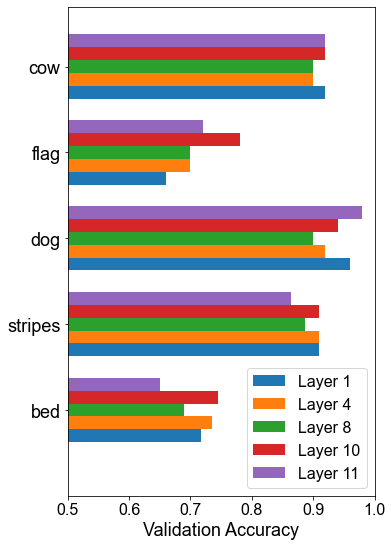

In [310]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

df = pandas.DataFrame(dict(graph=concepts, **concept_scores)) 

ind = np.arange(len(df))
width = 0.15

fig, ax = plt.subplots(figsize=[5.5, 9])
for l, layer in enumerate(layers):
    ax.barh(ind + l*width, df['Layer ' + str(layer)], width, label='Layer ' + str(layer + 1))

ax.set(yticks=ind + 2*width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend(prop={'family':'Arial', 'size':16})
ax.set_xlim([0.5, 1])

plt.xticks(fontname='Arial', fontsize=16)
plt.xlabel('Validation Accuracy', fontname='Arial', fontsize=18)
plt.yticks(fontname='Arial', fontsize=18)

# Set up the Model

In [311]:
model_name = "squeezenet"
batch_size = 8
num_epochs = 5
feature_extract = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(use_pretrained=True):
    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    input_size = 224
    return model_ft, input_size

model_ft, input_size = initialize_model()

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [312]:
class SqueezenetBottom(nn.Module):
    def __init__(self, original_model):
        super(SqueezenetBottom, self).__init__()
        self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:15], nn.Flatten())

    def forward(self, x):
        x = self.features(x)
        return x

class SqueezenetTop(nn.Module):
    def __init__(self, original_model):
        super(SqueezenetTop, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[1])

    def forward(self, x):
        x = x.view((-1, 512, 13, 13))
        x = self.features(x)
        x = x.view((-1, 1000))
        x = nn.Softmax(dim=-1)(x)
        return x

def get_model_parts(model):    
    model_bottom = SqueezenetBottom(model)
    model_top = SqueezenetTop(model)
    return model_bottom, model_top

model_bottom, model_top = get_model_parts(model_ft)
model_bottom.eval()
model_top.eval();

# Evaluation Methods

In [313]:
response = requests.get("https://git.io/JJkYN")
class_labels = response.text.split("\n")

In [314]:
def get_concept_scores(tensor, label):
    correct_idx = class_labels.index(label)
    concept_scores = {}
    embedding = model_bottom(tensor)
    original_preds = model_top(embedding).detach().numpy().squeeze()
    
    multiplier = 100000
    
    for key in concept_dict:
        coef, _, _ = concept_dict[key]
        plus = torch.from_numpy(embedding.detach().numpy() + multiplier*coef).float()
        plus_preds = model_top(plus)
        plus_diff = plus_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
        concept_scores[key] = float(plus_diff)
        
    concept_scores_list = sorted(concept_scores, key=concept_scores.get, reverse=True)    
    return original_preds[correct_idx], concept_scores, concept_scores_list    

In [316]:
img = PIL.Image.open("C:\\Users\\islam\\downloads\\zebra-fig1a.jpg").convert("RGB")
tensor = data_transforms(img).unsqueeze(0)

In [432]:
concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(10), 'rb'))
_, scores1, _ = get_concept_scores(tensor, 'zebra')

concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(7), 'rb'))
_, scores2, _ = get_concept_scores(tensor, 'zebra')

In [433]:
l1 = []
l2 = []

for c in scores1:
    l1.append(scores1[c])
    l2.append(scores2[c])    
    
from sklearn.metrics import r2_score
l1 = np.array(l1)
l1 = l1 / np.max(np.abs(l1))
l2 = np.array(l2)
l2 = l2 / np.max(np.abs(l2))
print(r2_score(l1, l2))

0.7861298157612224


In [434]:
from scipy.stats import pearsonr


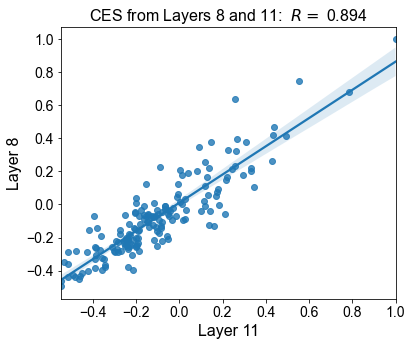

In [435]:
import seaborn as sns

plt.figure(figsize=[6, 5])
sns.regplot(x=l1, y=l2)
# plt.plot(l1, l2, '.')
plt.title('CES from Layers 8 and 11:  $R=$ ' + str(round(pearsonr(l1, l2)[0], 3)), fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('Layer 11', fontname='Arial', fontsize=16)
plt.ylabel('Layer 8', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);

In [436]:
concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(10), 'rb'))
_, scores1, _ = get_concept_scores(tensor, 'zebra')

concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(0), 'rb'))
_, scores2, _ = get_concept_scores(tensor, 'zebra')

In [437]:
l1 = []
l2 = []

for c in scores1:
    l1.append(scores1[c])
    l2.append(scores2[c])    
    
from sklearn.metrics import r2_score
l1 = np.array(l1)
l1 = l1 / np.max(np.abs(l1))
l2 = np.array(l2)
l2 = l2 / np.max(np.abs(l2))
print(r2_score(l1, l2))

0.6414172745652935


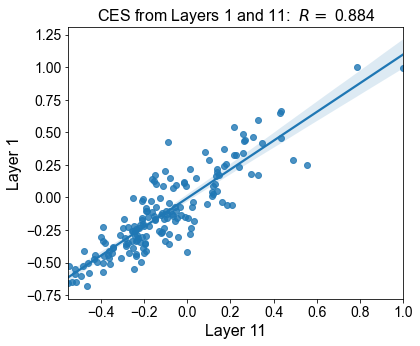

In [438]:
import seaborn as sns

plt.figure(figsize=[6, 5])
sns.regplot(x=l1, y=l2)
# plt.plot(l1, l2, '.')
plt.title('CES from Layers 1 and 11:  $R=$ ' + str(round(pearsonr(l1, l2)[0], 3)), fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('Layer 11', fontname='Arial', fontsize=16)
plt.ylabel('Layer 1', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);

In [372]:
concept_dict = pickle.load(open('sq_concepts_170.pkl', 'rb'))

In [388]:
def get_concept_scores_with_delta(tensor, label, multiplier):
    correct_idx = class_labels.index(label)
    concept_scores = {}
    embedding = model_bottom(tensor)
    original_preds = model_top(embedding).detach().numpy().squeeze()
        
    for key in concept_dict:
        coef, _, _ = concept_dict[key]
        plus = torch.from_numpy(embedding.detach().numpy() + multiplier*coef).float()
        plus_preds = model_top(plus)
        plus_diff = plus_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
        concept_scores[key] = float(plus_diff)
    
    m = np.max(np.abs(list(concept_scores.values())))
    for c in concept_scores:
        concept_scores[c] = concept_scores[c] / m
    
    concept_scores_list = sorted(concept_scores, key=concept_scores.get, reverse=True)    
    return original_preds[correct_idx], concept_scores, concept_scores_list    

In [422]:
all_scores = []
deltas = [1, 10, 100, 1000, 10000, 100000]

for delta in deltas:
    _, scores, lst = get_concept_scores_with_delta(tensor, 'zebra', delta)
    all_scores.append(scores)

In [423]:
top_concepts = lst[:5]

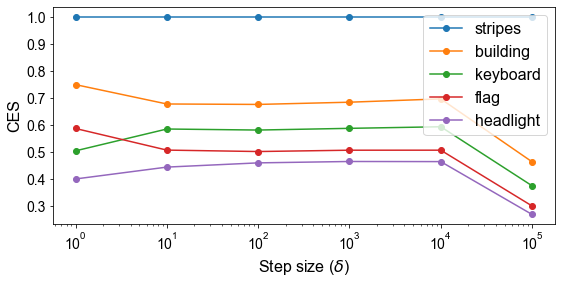

In [441]:
plt.figure(figsize=[9, 4])
for c in top_concepts:
    if c=="stripes":
        plt.semilogx(deltas, [1 for i in range(len(all_scores))], '-o', label=c)
    else:
        plt.semilogx(deltas, [all_scores[i][c] for i in range(len(all_scores))], '-o', label=c)
    
plt.legend(prop={'family':'Arial', 'size':16})
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('Step size ($\delta$)', fontname='Arial', fontsize=16)
plt.ylabel('CES', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);